In [1]:
### .libPaths()
suppressMessages(require(data.table))
suppressMessages(require(cowplot))
suppressMessages(require(Matrix))
suppressMessages(require(matrixStats))
suppressMessages(require(Seurat))
suppressMessages(require(mixtools))
suppressMessages(require(xlsx))
suppressMessages(require(subSeq))
suppressMessages(require(dplyr))
suppressMessages(require(ggplot2))
suppressMessages(require(pheatmap))
suppressMessages(require(jlmelville/uwot))
suppressMessages(require(SeuratDisk))
suppressMessages(require(tidyverse))

Warning message:
"package 'xlsx' was built under R version 4.0.3"
Warning message:
"package 'subSeq' was built under R version 4.0.3"
Warning message in if (!loaded) {:
"the condition has length > 1 and only the first element will be used"


In [2]:
#change to usable time measurements
second_to_humanReadableTime=function(t){
  #change second to a vector of hour,min,second
  h=floor(t/3600)
  t=t-h*3600
  m=floor(t/60)
  t=t-m*60
  s=t
  t=c(h,m,s)
  return(t)
}


Fill_Seurat_DR=function(SeuratOBJ,DRmatrix,DRtype="pca"){
    DR=new("dim.reduction", cell.embeddings = DRmatrix)
    SeuratOBJ@dr[[length(SeuratOBJ@dr)+1]]=DR
    names(SeuratOBJ@dr)[length(SeuratOBJ@dr)]=DRtype
    return(SeuratOBJ)
}

cross_combining=function(string1,string2){
    o=rep("",length(string1)*length(string2))
    k=0
    for(i in 1:length(string1)){
        for(j in 1:length(string2)){
            k=k+1
            o[k]=paste0(string1[i],"_",string2[j])
        } 
    }
    return(o)
}

In [3]:
#sample ids
sample_list=c('S203AKI_0110','S203AKI_1670_DSS','WT_0112','WT_1669_DSS',
'S203AKI_1652_DSS','S203AKI_1810','WT_1653_DSS','WT_1813')

In [4]:
#load and filter RNA data
ptm <- proc.time()
cellrangerOutDir="/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs"
tag=dir(path =cellrangerOutDir,full.names = F, recursive = F)
set.seed(123)
tagdir=na.omit(paste0(cellrangerOutDir,"/",sample_list,"/outs/filtered_feature_bc_matrix/")[gtools::mixedorder(tag)])
tagdir
t2g=readRDS("/home/jkanbar/genomeFiles/mm10_t2g_R35.Rds")
MTlist=t2g$ext_gene[t2g$chromosome_name=="MT"]
nGeneThreshold=400
mitoUpperThreshold=0.2 #smaller than 1
mitoLowerThreshold=0.01
upper_ranking_threshold_pecentage=0.1/100

[1] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/S203AKI_0110/outs/filtered_feature_bc_matrix/"    
[2] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/S203AKI_1670_DSS/outs/filtered_feature_bc_matrix/"
[3] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/WT_0112/outs/filtered_feature_bc_matrix/"         
[4] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/WT_1669_DSS/outs/filtered_feature_bc_matrix/"     
[5] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/S203AKI_1652_DSS/outs/filtered_feature_bc_matrix/"
[6] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/S203AKI_1810/outs/filtered_feature_bc_matrix/"    
[7] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/WT_1653_DSS/outs/filtered_feature_bc_matrix/"     
[8] "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/WT_1813/outs/filtered_feature_bc_matrix/"

In [5]:
#combining of all single library
set.seed(123)
cell_per_sample = 10000
gene_bc_matrix=list()
#sample_num=rep(0,length(tagdir))
#batch=c()
rna_protein_matrix = list()


for(i in 1:length(tagdir)){
    gene_bc_matrix[[i]]=Read10X(tagdir[i])
    gene_bc_matrix[[i]]= gene_bc_matrix[[i]]
    temp=gene_bc_matrix[[i]][,colSums(gene_bc_matrix[[i]])>nrow(gene_bc_matrix[[i]])/100] 
    enoughGene=colSums(temp>0)>=nGeneThreshold
    gene_bc_matrix[[i]]=gene_bc_matrix[[i]][,enoughGene]
    gene_bc_matrix[[i]]=t(gene_bc_matrix[[i]])
    MTsum=rowSums(gene_bc_matrix[[i]][,colnames(gene_bc_matrix[[i]]) %in% MTlist])
    toomuchmito=MTsum/rowSums(gene_bc_matrix[[i]])>mitoUpperThreshold
    nomito=MTsum==0
    gene_bc_matrix[[i]]=gene_bc_matrix[[i]][(!toomuchmito) & (!nomito),]  
    #sample_num[i]=ncol(gene_bc_matrix[[i]])
    #batch=c(batch,rep(i,nrow(gene_bc_matrix[[i]])))
    if(nrow(gene_bc_matrix[[i]])>cell_per_sample){
         topick <- sample(1:nrow(gene_bc_matrix[[i]]),cell_per_sample)
         gene_bc_matrix[[i]]=gene_bc_matrix[[i]][topick,]
    }
    t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
    message(paste0(i,"/",length(tagdir)," loading done: ",t[1],"hr",t[2],"min",round(t[3]),"s"))
    message(paste0("droped by too few gene:",sum(!enoughGene),"| mito:",sum(toomuchmito),"|",sum(nomito)))
    gene_bc_matrix[[i]]=t(gene_bc_matrix[[i]])
    #tempSeurat <- CreateSeuratObject(counts = gene_bc_matrix[[i]])
    #tempSeurat <- NormalizeData(tempSeurat,normalization.method = "LogNormalize", scale.factor = 10000)
    #gene_bc_matrix_norm[[i]] <- Matrix(tempSeurat@assays$RNA@data, sparse = TRUE)
    #rm(tempSeurat)
    rna_protein_matrix[[i]] <- gene_bc_matrix[[i]]
}

1/8 loading done: 0hr0min15s

droped by too few gene:636| mito:65|21

2/8 loading done: 0hr0min25s

droped by too few gene:183| mito:40|11

3/8 loading done: 0hr0min37s

droped by too few gene:584| mito:31|9

4/8 loading done: 0hr0min47s

droped by too few gene:571| mito:101|12

5/8 loading done: 0hr0min59s

droped by too few gene:672| mito:91|9

6/8 loading done: 0hr1min8s

droped by too few gene:303| mito:16|12

7/8 loading done: 0hr1min17s

droped by too few gene:339| mito:50|11

8/8 loading done: 0hr1min28s

droped by too few gene:249| mito:21|11



In [6]:
ExpressionMat=do.call("cbind",gene_bc_matrix)
ExpressionMat = t(ExpressionMat)
ExpressionMat=ExpressionMat[,colSums(ExpressionMat)>2]
ExpressionBinaryMat=ExpressionMat>=1
ExpressionMat=ExpressionMat[,colSums(ExpressionBinaryMat)>nrow(ExpressionMat)/100]
batch=c()

#filter the outlier for each gene:
upper_ranking_threshold=ceiling(upper_ranking_threshold_pecentage*nrow(ExpressionMat))
ExpressionMat=apply(ExpressionMat,2,function(x){
    ordered_x=sort(x,decreasing=T)
    max_threshold=ordered_x[upper_ranking_threshold]
    x[x>max_threshold]=max_threshold
    return(x)
})

#remove duplicate cells
duplicate_cell=which(duplicated(ExpressionMat))
if(length(duplicate_cell)>0){
    batch=batch[-duplicate_cell]
    ExpressionMat=ExpressionMat[-duplicate_cell,]
}

dim(ExpressionMat)

[1] 80000 11030

In [7]:
#merge matrices per object into one large matrix 
geneList <- c(colnames(ExpressionMat))
rna_protein_seurat_matrix=list()
rna_protein_matrix_norm = list()
gene_bc_matrix_norm=list()

for(i in 1:length(rna_protein_matrix)){
    rna_protein_matrix[[i]] <- rna_protein_matrix[[i]][geneList, ]
    rownames(rna_protein_matrix[[i]]) <- gsub('_','-',rownames(rna_protein_matrix[[i]]))
    
    tempRNASeurat <- CreateSeuratObject(counts = rna_protein_matrix[[i]][colnames(ExpressionMat),colnames(gene_bc_matrix[[i]])])
    tempRNASeurat <- NormalizeData(tempRNASeurat,normalization.method = "LogNormalize", scale.factor = 10000)
    gene_bc_matrix_norm[[i]] <- Matrix(tempRNASeurat@assays$RNA@data, sparse = TRUE)
    rm(tempRNASeurat)
    rna_protein_matrix_norm[[i]] <- rbind(gene_bc_matrix_norm[[i]])
    rownames(rna_protein_matrix_norm[[i]]) <- gsub('_','-',rownames(rna_protein_matrix_norm[[i]]))
    
    rna_protein_seurat_matrix[[i]] <- CreateSeuratObject(counts = rna_protein_matrix[[i]], 
                                              project = sample_list[i])
    rna_protein_seurat_matrix[[i]]@assays$RNA@data <- rna_protein_matrix_norm[[i]]
    
}

rna_protein_seurat_matrix_temp <- rna_protein_seurat_matrix
rna_protein_seurat_matrix_temp[[1]] <- NULL
ExpRNA_Pro_Seurat <- merge(rna_protein_seurat_matrix[[1]],
                           y = rna_protein_seurat_matrix_temp,)

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [9]:
origIdent <- ExpRNA_Pro_Seurat@meta.data$orig.ident
batch = c()
for(i in 1:length(table(origIdent))){ 
    batch=c(batch,rep(i,table(origIdent)[[i]]))
}
table(batch)

#Adding patient, health, and tissue assignment metadata

#DSS Assignment
patient_type=sapply(strsplit(sample_list, split='_', fixed=TRUE), function(x) (x[3]))
patient_type= patient_type %>% replace_na("No DSS")
patient_assignment=rep("",length(ExpRNA_Pro_Seurat@meta.data$orig.ident))
for(i in 1:length(patient_type)){
    patient_assignment[batch %in% grep(patient_type[i],sample_list)]=patient_type[i]
}
ExpRNA_Pro_Seurat <- AddMetaData(object = ExpRNA_Pro_Seurat, 
                                 metadata = patient_assignment, col.name = 'DSS_Assignment')
                           
#Tissue Type Assignment
day_type=sapply(strsplit(sample_list, split='_', fixed=TRUE), function(x) (x[1]))
day_assignment=rep("",length(ExpRNA_Pro_Seurat@meta.data$orig.ident))
for(i in 1:length(day_type)){
    day_assignment[batch %in% grep(day_type[i],sample_list)]=day_assignment[i]
}
ExpRNA_Pro_Seurat <- AddMetaData(object = ExpRNA_Pro_Seurat, 
                                 metadata = day_assignment, col.name = 'Genotype_Assignment')

batch
    1     2     3     4     5     6     7     8 
10000 10000 10000 10000 10000 10000 10000 10000 

In [13]:
#Adding 'dss' metadata
dss = c()
for(i in 1:length(ExpRNA_Pro_Seurat@meta.data$orig.ident)){
    dss[i] <- Seurat:::ExtractField(ExpRNA_Pro_Seurat@meta.data[,1][i], field = 3, delim = "_")
}
ExpRNA_Pro_Seurat <- AddMetaData(object =  ExpRNA_Pro_Seurat, 
                                 metadata = dss, col.name = 'DSS_Assignment')

In [19]:
#Custom plotting functions
Subsample_by_group=function(assign_vector,tag_total_num){
    ori_tot=length(assign_vector)
    if(tag_total_num>=ori_tot){
        message("no need to down sample")
        return(1:length(assign_vector))
    }else{
        types=unique(assign_vector)
        tags=c()
        for(i in 1:length(types)){
            in_gp=which(assign_vector==types[i])
            tags=c(tags,sample(in_gp,round(length(in_gp)/ori_tot*tag_total_num))) 
        }
        return(tags)
    }
}

jColors <- c('#4575b4','#d73027','#66bd63')


plotByGroup=function(Exp_Seurat,
                     Group_assignment, #must match the cells order in Exp_Seurat@dr
                     Group_type=NULL, #provide the order of Group_type
                     random_order=T,
                     embedding_type="tsne",
                     plotGroupOnly=NULL, #only plot the identified group
                     backGroundGroup=NULL, #bkg group cell as grey
                     Addtext=F,
                     main_title="",
                     target_dot_number=10000,
                     tag_cell=NULL, #plot only tag cells
                     tagcol=NULL,
                     Addlegend=T,
                     rm_small_group=F){
    
    if(sum(is.na(Group_assignment))!=0){
        warning("NAs in Group_assignment")
    }

    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    #select target cell
    if(is.null(tag_cell)){
        tag_cell=1:length(Group_assignment)
    }
    plotting_coordinates=plotting_coordinates[tag_cell,]
    Group_assignment=Group_assignment[tag_cell]
    
    #rm groups that's too small
    if(rm_small_group){
        gp_size=table(Group_assignment)
        gp2rm=names(gp_size)[gp_size*min(1,target_dot_number/length(Group_assignment))<10]
        if(length(gp2rm)>0){
            to_keep=which(!Group_assignment %in% gp2rm)
            Group_assignment=Group_assignment[to_keep]
            plotting_coordinates=plotting_coordinates[to_keep,]
        }
    }
    
    Group_assignment=as.character(Group_assignment)
   
    #remove not used grouptype
    if(is.null(Group_type)){
        Group_type=unique(Group_assignment)
        Group_type=Group_type[gtools::mixedorder(Group_type)]
    }else{
        Group_type=Group_type[Group_type %in% Group_assignment]
    }
    
    #color by group id
    if(is.null(tagcol)){
        if(length(Group_type)<=9){
            tagcol=RColorBrewer::brewer.pal(max(3,length(Group_type)),"Set1")
        }else{
            tagcol=colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))
            tagcol=tagcol(length(Group_type))
        }
    }
    
    #reduce dot number to target_dot_number
    tot_dot_num=nrow(plotting_coordinates)
    if(tot_dot_num>target_dot_number){
        cell_inFg=which(!Group_assignment %in% backGroundGroup)
        cell_inBkg=which(Group_assignment %in% backGroundGroup)
        
        target_percentage_Fg=2*length(cell_inFg)/(length(Group_assignment)+length(cell_inFg))
        target_percentage_bkg=length(cell_inBkg)/(length(Group_assignment)+length(cell_inFg))
        
        if(target_percentage_bkg>0.5){
            get1w_Fg = Subsample_by_group(Group_assignment[cell_inFg], round(target_dot_number*target_percentage_Fg))
            get1w_Bkg = Subsample_by_group(Group_assignment[cell_inBkg], round(target_dot_number*target_percentage_bkg))
            get1w = c(cell_inFg[get1w_Fg],cell_inBkg[get1w_Bkg])
        }else{
            get1w=Subsample_by_group(Group_assignment,target_dot_number)
        }
        plotting_coordinates=plotting_coordinates[get1w,]
        cluster_assign=Group_assignment[get1w]
    }else{
        cluster_assign=Group_assignment
    }    
    
    if(random_order){
        random_order=sample(1:length(cluster_assign),length(cluster_assign))
    }else{
        random_order=1:length(cluster_assign)
    }
    
    #calculate cluster center
    if(Addtext){
        cluster_center=matrix(0,length(Group_type),2)
        not_present=c()
        for(i in 1:length(Group_type)){
            #check exist or not
            if(sum(cluster_assign==Group_type[i],na.rm=T)==0){
                not_present=c(not_present,i)
                next
            }
            
            #check if only 1 dot
            if(sum(cluster_assign==Group_type[i],na.rm=T)<3){
                cluster_center[i,]=plotting_coordinates[which(cluster_assign==Group_type[i])[1],]
            }else{
                tagcoord=plotting_coordinates[cluster_assign==Group_type[i],]
                quick_kmean=kmeans(tagcoord,centers=2)
                center=quick_kmean$centers[which.max(table(quick_kmean$cluster)),]
                cluster_center[i,]=tagcoord[which.min(proxy::dist(tagcoord,t(center))),]            
            }
        }
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2])  
    if(is.null(plotGroupOnly)){
        if(!is.null(backGroundGroup)){
            background_cell=which(cluster_assign %in% backGroundGroup)
            random_order_b=random_order[random_order %in% background_cell]
            if(length(background_cell)==0){
                warning("backGroundGroup not found in assignment")
                #no backgroud
                plot(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5,
                     main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))   
            }else{
                #plot if yes background exist
                plot(plotting_coordinates[random_order_b,],pch=19,col="gray",cex=0.5,
                     main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))
                foreground_cell=which(!cluster_assign %in% backGroundGroup)
                random_order=random_order[random_order %in% foreground_cell]
                points(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5)
                tagcol[Group_type %in% backGroundGroup]="gray"
            }
        }else{
            #no backgroud
            plot(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5,
                 main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))        
        }
        if(Addtext){text(cluster_center[,1],cluster_center[,2],label=Group_type,font=2,cex=1.2)}
        if(Addlegend){legend(x=37,y=32,Group_type,bty = "n",lty=0,pch=19,col=tagcol)}
    }else{
        if(!plotGroupOnly %in% Group_type){
            stop("cell type to plot is missing in current data")
        }
        tag_cluster_num=match(plotGroupOnly,Group_type)
        plot(plotting_coordinates[!cluster_assign %in% plotGroupOnly,],pch=19,col="gray",cex=0.5,
             main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))
        for(i in 1:length(plotGroupOnly)){
            points(plotting_coordinates[cluster_assign==plotGroupOnly[i],],pch=19,col=tagcol[which(Group_type==plotGroupOnly[i])],cex=0.5)
        }
        if(Addtext){text(cluster_center[tag_cluster_num,1],cluster_center[tag_cluster_num,2]
                         ,label=Group_type[tag_cluster_num],font=2,cex=1.2)}      
        if(Addlegend){legend(x=37,y=32,Group_type[tag_cluster_num],bty = "n",lty=0,pch=19,col=tagcol[tag_cluster_num])}
    }
}

plotByScore=function(Exp_Seurat,
                     Score_assignment,
                     random_order=T,
                     embedding_type="tsne",
                     main_title="",
                     colorSD=1,
                     colorCenter=mean(Score_assignment),
                     target_dot_number=10000,
                     tag_cell=NULL,
                     bkg_cell=NULL, #don't supply bkg if tag is empty
                     cols=NULL,
                     bkg_col="gray",
                     Addlegend=T) #tag_cell only subsample Exp_Seurat but not Score_assignment
{   
    Score_assignment=as.numeric(Score_assignment)
    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    if(is.null(tag_cell)){
        bkg_cell=NULL
    }
    
    if(is.null(bkg_cell)){
        #reduce dot number to target_dot_number
        tot_dot_num=nrow(plotting_coordinates)
        if(tot_dot_num>target_dot_number){
            get1w=Subsample_by_group(Exp_Seurat@meta.data$orig.ident,target_dot_number)
        }else{
            get1w=1:tot_dot_num
        }
    }else{
        get1w=bkg_cell
    }
    
    if(is.null(tag_cell)){
        plotting_coordinates=plotting_coordinates[get1w,]
        Score_assignment=Score_assignment[get1w]
        foreground=1:length(get1w)
        background=1
    }else{
        allc=union(tag_cell,get1w)
        plotting_coordinates=plotting_coordinates[allc,]
        foreground=which(allc %in% tag_cell)
        background=which(!allc %in% tag_cell)
    }
    
    if(random_order){
        random_order=sample(1:length(foreground),length(foreground))
        foreground=foreground[random_order]
    }
    
    #     minScore <- 0
    #     maxScore <- 1
    #     scores = (Score_assignment-min(Score_assignment))/(max(Score_assignment)-min(Score_assignment))
    
    #     n <- length(scores)
    #     secondHI <- sort(scores,partial=n-1)[n-1]
    #     scores <- scores/secondHI
    
    #      if(is.null(cols)){
    #          rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(5,"RdBu")))
    #          lowerbound=minScore
    #          upperbound=maxScore
    #          breaks=c(-Inf,seq(minScore, maxScore, length.out=25),Inf)
    #          cols=rbPal(26)[as.numeric(cut(scores,breaks = breaks, include.lowest=TRUE))]
    #      }
      
    if(is.null(cols)){
        rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))
        lowerbound=colorCenter-colorSD*sd(Score_assignment)
        middlebound=colorCenter-colorSD*mean(Score_assignment)
        upperbound=colorCenter+colorSD*sd(Score_assignment)
        breaks=c(-Inf,seq(lowerbound, upperbound, length.out=25),Inf)
        cols=rbPal(26)[as.numeric(cut(Score_assignment,breaks = breaks, include.lowest=TRUE))]
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2]) 
    #plot bkg
    plot(plotting_coordinates[background,],pch=19,cex=0.3,col=bkg_col,xlim=c(minx,maxx+0.3*(maxx-minx)),main=paste(main_title,embedding_type),ylim=c(miny,maxy))      
    points(plotting_coordinates[foreground,],pch=19,cex=0.5,col=cols[random_order])  
    if(Addlegend){legend(x=30,y=30,legend=round(seq(lowerbound, upperbound, length.out=5),2),bty = "n",lty=0,pch=19,col=rbPal(5))}
    scoring <- data.frame(lowerbound,upperbound)
    colnames(scoring) <- c("lowerbound","upperbound")
    print(scoring)
    return(as.data.frame(scoring))
}

plotByUMAPScore=function(Exp_Seurat,
                     Score_assignment,
                     random_order=T,
                     embedding_type="umap",
                     main_title="",
                     colorSD=1,
                     colorCenter=mean(Score_assignment),
                     target_dot_number=10000,
                     tag_cell=NULL,
                     bkg_cell=NULL, #don't supply bkg if tag is empty
                     cols=NULL,
                     bkg_col="gray",
                     Addlegend=T) #tag_cell only subsample Exp_Seurat but not Score_assignment
{   
    Score_assignment=as.numeric(Score_assignment)
    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    if(is.null(tag_cell)){
        bkg_cell=NULL
    }
    
    if(is.null(bkg_cell)){
        #reduce dot number to target_dot_number
        tot_dot_num=nrow(plotting_coordinates)
        if(tot_dot_num>target_dot_number){
            get1w=Subsample_by_group(Exp_Seurat@meta.data$orig.ident,target_dot_number)
        }else{
            get1w=1:tot_dot_num
        }
    }else{
        get1w=bkg_cell
    }
    
    if(is.null(tag_cell)){
        plotting_coordinates=plotting_coordinates[get1w,]
        Score_assignment=Score_assignment[get1w]
        foreground=1:length(get1w)
        background=1
    }else{
        allc=union(tag_cell,get1w)
        plotting_coordinates=plotting_coordinates[allc,]
        foreground=which(allc %in% tag_cell)
        background=which(!allc %in% tag_cell)
    }
    
    if(random_order){
        random_order=sample(1:length(foreground),length(foreground))
        foreground=foreground[random_order]
    }
    
    #     minScore <- 0
    #     maxScore <- 1
    #     scores = (Score_assignment-min(Score_assignment))/(max(Score_assignment)-min(Score_assignment))
    
    #     n <- length(scores)
    #     secondHI <- sort(scores,partial=n-1)[n-1]
    #     scores <- scores/secondHI
    
    #      if(is.null(cols)){
    #          rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(5,"RdBu")))
    #          lowerbound=minScore
    #          upperbound=maxScore
    #          breaks=c(-Inf,seq(minScore, maxScore, length.out=25),Inf)
    #          cols=rbPal(26)[as.numeric(cut(scores,breaks = breaks, include.lowest=TRUE))]
    #      }
      
    if(is.null(cols)){
        rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))
        lowerbound=colorCenter-colorSD*sd(Score_assignment)
        middlebound=colorCenter-colorSD*mean(Score_assignment)
        upperbound=colorCenter+colorSD*sd(Score_assignment)
        breaks=c(-Inf,seq(lowerbound, upperbound, length.out=25),Inf)
        cols=rbPal(26)[as.numeric(cut(Score_assignment,breaks = breaks, include.lowest=TRUE))]
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2]) 
    #plot bkg
    plot(plotting_coordinates[background,],pch=19,cex=0.3,col=bkg_col,xlim=c(minx,maxx+0.3*(maxx-minx)),main=paste(main_title,embedding_type),ylim=c(miny,maxy))      
    points(plotting_coordinates[foreground,],pch=19,cex=0.5,col=cols[random_order])  
    if(Addlegend){legend(x=5.5,y=9.5,legend=round(seq(lowerbound, upperbound, length.out=5),2),bty = "n",lty=0,pch=19,col=rbPal(5))}
    scoring <- data.frame(lowerbound,upperbound)
    colnames(scoring) <- c("lowerbound","upperbound")
    print(scoring)
    return(as.data.frame(scoring))
}

plotByUMAPGroup=function(Exp_Seurat,
                     Group_assignment, #must match the cells order in Exp_Seurat@dr
                     Group_type=NULL, #provide the order of Group_type
                     random_order=T,
                     embedding_type="umap",
                     plotGroupOnly=NULL, #only plot the identified group
                     backGroundGroup=NULL, #bkg group cell as grey
                     Addtext=F,
                     main_title="",
                     target_dot_number=10000,
                     tag_cell=NULL, #plot only tag cells
                     tagcol=NULL,
                     Addlegend=T,
                     rm_small_group=F){
    
    if(sum(is.na(Group_assignment))!=0){
        warning("NAs in Group_assignment")
    }

    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    #select target cell
    if(is.null(tag_cell)){
        tag_cell=1:length(Group_assignment)
    }
    plotting_coordinates=plotting_coordinates[tag_cell,]
    Group_assignment=Group_assignment[tag_cell]
    
    #rm groups that's too small
    if(rm_small_group){
        gp_size=table(Group_assignment)
        gp2rm=names(gp_size)[gp_size*min(1,target_dot_number/length(Group_assignment))<10]
        if(length(gp2rm)>0){
            to_keep=which(!Group_assignment %in% gp2rm)
            Group_assignment=Group_assignment[to_keep]
            plotting_coordinates=plotting_coordinates[to_keep,]
        }
    }
    
    Group_assignment=as.character(Group_assignment)
   
    #remove not used grouptype
    if(is.null(Group_type)){
        Group_type=unique(Group_assignment)
        Group_type=Group_type[gtools::mixedorder(Group_type)]
    }else{
        Group_type=Group_type[Group_type %in% Group_assignment]
    }
    
    #color by group id
    if(is.null(tagcol)){
        if(length(Group_type)<=9){
            tagcol=RColorBrewer::brewer.pal(max(3,length(Group_type)),"Set1")
        }else{
            tagcol=colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))
            tagcol=tagcol(length(Group_type))
        }
    }
    
    #reduce dot number to target_dot_number
    tot_dot_num=nrow(plotting_coordinates)
    if(tot_dot_num>target_dot_number){
        cell_inFg=which(!Group_assignment %in% backGroundGroup)
        cell_inBkg=which(Group_assignment %in% backGroundGroup)
         
        target_percentage_Fg=2*length(cell_inFg)/(length(Group_assignment)+length(cell_inFg))
        target_percentage_bkg=length(cell_inBkg)/(length(Group_assignment)+length(cell_inFg))
        
        if(target_percentage_bkg>0.5){
            get1w_Fg = Subsample_by_group(Group_assignment[cell_inFg], round(target_dot_number*target_percentage_Fg))
            get1w_Bkg = Subsample_by_group(Group_assignment[cell_inBkg], round(target_dot_number*target_percentage_bkg))
            get1w = c(cell_inFg[get1w_Fg],cell_inBkg[get1w_Bkg])
        }else{
            get1w=Subsample_by_group(Group_assignment,target_dot_number)
        }
        plotting_coordinates=plotting_coordinates[get1w,]
        cluster_assign=Group_assignment[get1w]
    }else{
        cluster_assign=Group_assignment
    }    
    
    if(random_order){
        random_order=sample(1:length(cluster_assign),length(cluster_assign))
    }else{
        random_order=1:length(cluster_assign)
    }
    
    #calculate cluster center
    if(Addtext){
        cluster_center=matrix(0,length(Group_type),2)
        not_present=c()
        for(i in 1:length(Group_type)){
            #check exist or not
            if(sum(cluster_assign==Group_type[i],na.rm=T)==0){
                not_present=c(not_present,i)
                next
            }
            
            #check if only 1 dot
            if(sum(cluster_assign==Group_type[i],na.rm=T)<3){
                cluster_center[i,]=plotting_coordinates[which(cluster_assign==Group_type[i])[1],]
            }else{
                tagcoord=plotting_coordinates[cluster_assign==Group_type[i],]
                quick_kmean=kmeans(tagcoord,centers=2)
                center=quick_kmean$centers[which.max(table(quick_kmean$cluster)),]
                cluster_center[i,]=tagcoord[which.min(proxy::dist(tagcoord,t(center))),]            
            }
        }
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2])  
    if(is.null(plotGroupOnly)){
        if(!is.null(backGroundGroup)){
            background_cell=which(cluster_assign %in% backGroundGroup)
            random_order_b=random_order[random_order %in% background_cell]
            if(length(background_cell)==0){
                warning("backGroundGroup not found in assignment")
                #no backgroud
                plot(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5,
                     main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))   
            }else{
                #plot if yes background exist
                plot(plotting_coordinates[random_order_b,],pch=19,col="gray",cex=0.5,
                     main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))
                foreground_cell=which(!cluster_assign %in% backGroundGroup)
                random_order=random_order[random_order %in% foreground_cell]
                points(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5)
                tagcol[Group_type %in% backGroundGroup]="gray"
            }
        }else{
            #no backgroud
            plot(plotting_coordinates[random_order,],pch=19,col=tagcol[match(cluster_assign,Group_type)][random_order],cex=0.5,
                 main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))        
        }
        if(Addtext){text(cluster_center[,1],cluster_center[,2],label=Group_type,font=2,cex=1.2)}
        if(Addlegend){legend(x=15,y=9,Group_type,bty = "n",lty=0,pch=19,col=tagcol)}
    }else{
        if(!plotGroupOnly %in% Group_type){
            stop("cell type to plot is missing in current data")
        }
        tag_cluster_num=match(plotGroupOnly,Group_type)
        plot(plotting_coordinates[!cluster_assign %in% plotGroupOnly,],pch=19,col="gray",cex=0.5,
             main=paste(main_title,embedding_type),ylim=c(miny,maxy),xlim=c(minx,maxx+0.3*(maxx-minx)))
        for(i in 1:length(plotGroupOnly)){
            points(plotting_coordinates[cluster_assign==plotGroupOnly[i],],pch=19,col=tagcol[which(Group_type==plotGroupOnly[i])],cex=0.5)
        }
        if(Addtext){text(cluster_center[tag_cluster_num,1],cluster_center[tag_cluster_num,2]
                         ,label=Group_type[tag_cluster_num],font=2,cex=1.2)}      
        if(Addlegend){legend(x=15,y=9,Group_type[tag_cluster_num],bty = "n",lty=0,pch=19,col=tagcol[tag_cluster_num])}
    }
}

FixedPlotByScore=function(Exp_Seurat,
                     Score_assignment,
                     lowerbound,
                     upperbound,
                     random_order=T,
                     embedding_type="tsne",
                     main_title="",
                     colorSD=1,
                     colorCenter=mean(Score_assignment),
                     target_dot_number=10000,
                     tag_cell=NULL,
                     bkg_cell=NULL, #don't supply bkg if tag is empty
                     cols=NULL,
                     bkg_col="gray",
                     Addlegend=T) #tag_cell only subsample Exp_Seurat but not Score_assignment
{   
    Score_assignment=as.numeric(Score_assignment)
    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    if(is.null(tag_cell)){
        bkg_cell=NULL
    }
    
    if(is.null(bkg_cell)){
        #reduce dot number to target_dot_number
        tot_dot_num=nrow(plotting_coordinates)
        if(tot_dot_num>target_dot_number){
            get1w=Subsample_by_group(Exp_Seurat@meta.data$orig.ident,target_dot_number)
        }else{
            get1w=1:tot_dot_num
        }
    }else{
        get1w=bkg_cell
    }
    
    if(is.null(tag_cell)){
        plotting_coordinates=plotting_coordinates[get1w,]
        Score_assignment=Score_assignment[get1w]
        foreground=1:length(get1w)
        background=1
    }else{
        allc=union(tag_cell,get1w)
        plotting_coordinates=plotting_coordinates[allc,]
        foreground=which(allc %in% tag_cell)
        background=which(!allc %in% tag_cell)
    }
    
    if(random_order){
        random_order=sample(1:length(foreground),length(foreground))
        foreground=foreground[random_order]
    }
    
    #     minScore <- 0
    #     maxScore <- 1
    #     scores = (Score_assignment-min(Score_assignment))/(max(Score_assignment)-min(Score_assignment))
    
    #     n <- length(scores)
    #     secondHI <- sort(scores,partial=n-1)[n-1]
    #     scores <- scores/secondHI
    
    #      if(is.null(cols)){
    #          rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(5,"RdBu")))
    #          lowerbound=minScore
    #          upperbound=maxScore
    #          breaks=c(-Inf,seq(minScore, maxScore, length.out=25),Inf)
    #          cols=rbPal(26)[as.numeric(cut(scores,breaks = breaks, include.lowest=TRUE))]
    #      }
      
    if(is.null(cols)){
        rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))
        lowerbound=as.numeric(lowerbound)
        upperbound=as.numeric(upperbound)
        breaks=c(-Inf,seq(lowerbound, upperbound, length.out=25),Inf)
        cols=rbPal(26)[as.numeric(cut(Score_assignment,breaks = breaks, include.lowest=TRUE))]
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2]) 
    #plot bkg
    plot(plotting_coordinates[background,],pch=19,cex=0.3,col=bkg_col,xlim=c(minx,maxx+0.3*(maxx-minx)),main=paste(main_title,embedding_type),ylim=c(miny,maxy))      
    points(plotting_coordinates[foreground,],pch=19,cex=0.5,col=cols[random_order])  
    if(Addlegend){legend(x=50,y=20,legend=round(seq(lowerbound, upperbound, length.out=5),2),bty = "n",lty=0,pch=19,col=rbPal(5))}
}

FixedPlotByScoreUMAP=function(Exp_Seurat,
                     Score_assignment,
                     lowerbound,
                     upperbound,
                     random_order=T,
                     embedding_type="umap",
                     main_title="",
                     colorSD=1,
                     colorCenter=mean(Score_assignment),
                     target_dot_number=10000,
                     tag_cell=NULL,
                     bkg_cell=NULL, #don't supply bkg if tag is empty
                     cols=NULL,
                     bkg_col="gray",
                     Addlegend=T) #tag_cell only subsample Exp_Seurat but not Score_assignment
{   
    Score_assignment=as.numeric(Score_assignment)
    eval(parse(text=paste0("plotting_coordinates=Exp_Seurat@reductions$",embedding_type,"@cell.embeddings[,1:2]")))
    
    if(is.null(tag_cell)){
        bkg_cell=NULL
    }
    
    if(is.null(bkg_cell)){
        #reduce dot number to target_dot_number
        tot_dot_num=nrow(plotting_coordinates)
        if(tot_dot_num>target_dot_number){
            get1w=Subsample_by_group(Exp_Seurat@meta.data$orig.ident,target_dot_number)
        }else{
            get1w=1:tot_dot_num
        }
    }else{
        get1w=bkg_cell
    }
    
    if(is.null(tag_cell)){
        plotting_coordinates=plotting_coordinates[get1w,]
        Score_assignment=Score_assignment[get1w]
        foreground=1:length(get1w)
        background=1
    }else{
        allc=union(tag_cell,get1w)
        plotting_coordinates=plotting_coordinates[allc,]
        foreground=which(allc %in% tag_cell)
        background=which(!allc %in% tag_cell)
    }
    
    if(random_order){
        random_order=sample(1:length(foreground),length(foreground))
        foreground=foreground[random_order]
    }
    
    #     minScore <- 0
    #     maxScore <- 1
    #     scores = (Score_assignment-min(Score_assignment))/(max(Score_assignment)-min(Score_assignment))
    
    #     n <- length(scores)
    #     secondHI <- sort(scores,partial=n-1)[n-1]
    #     scores <- scores/secondHI
    
    #      if(is.null(cols)){
    #          rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(5,"RdBu")))
    #          lowerbound=minScore
    #          upperbound=maxScore
    #          breaks=c(-Inf,seq(minScore, maxScore, length.out=25),Inf)
    #          cols=rbPal(26)[as.numeric(cut(scores,breaks = breaks, include.lowest=TRUE))]
    #      }
      
    if(is.null(cols)){
        rbPal <- colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))
        lowerbound=as.numeric(lowerbound)
        upperbound=as.numeric(upperbound)
        breaks=c(-Inf,seq(lowerbound, upperbound, length.out=25),Inf)
        cols=rbPal(26)[as.numeric(cut(Score_assignment,breaks = breaks, include.lowest=TRUE))]
    }
    
    maxx=max(plotting_coordinates[,1])
    minx=min(plotting_coordinates[,1])
    maxy=max(plotting_coordinates[,2])
    miny=min(plotting_coordinates[,2]) 
    #plot bkg
    plot(plotting_coordinates[background,],pch=19,cex=0.3,col=bkg_col,xlim=c(minx,maxx+0.3*(maxx-minx)),main=paste(main_title,embedding_type),ylim=c(miny,maxy))      
    points(plotting_coordinates[foreground,],pch=19,cex=0.5,col=cols[random_order])  
    if(Addlegend){legend(x=14,y=5,legend=round(seq(lowerbound, upperbound, length.out=5),2),bty = "n",lty=0,pch=19,col=rbPal(5))}
}

In [ ]:
#standard Seurat downstream analysis (find variable features, scale data, run PCA, tsne/umap)

In [21]:
Exp_integrated <- ExpRNA_Pro_Seurat
DefaultAssay(Exp_integrated) <- "RNA"
Exp_integrated <- FindVariableFeatures(object = Exp_integrated, selection.method = "vst", 
        nfeatures = 3000, verbose = FALSE)


In [22]:
Exp_integrated@assays$RNA@data=as.matrix(Exp_integrated@assays$RNA@data)

In [23]:
Exp_integrated <- ScaleData(object = Exp_integrated, verbose = FALSE)

In [24]:
rna_idx=grep('\\|',rownames(Exp_integrated@assays$RNA@scale.data))
rna_scale=nrow(Exp_integrated@assays$RNA@scale.data)/length(rna_idx)*0.1
Exp_integrated@assays$RNA@scale.data[rna_idx,]=Exp_integrated@assays$RNA@scale.data[rna_idx,]*rna_scale

In [25]:
Exp_feature_names <- rownames(Exp_integrated@assays$RNA)

In [26]:
Exp_integrated <- RunPCA(object = Exp_integrated, npcs = 30, verbose = FALSE, features = Exp_feature_names)

In [27]:
protein_idx=grep('\\|',rownames(Exp_integrated@assays$RNA@scale.data))
protein_scale=nrow(Exp_integrated@assays$RNA@scale.data)/length(protein_idx)*0.1
Exp_integrated@assays$RNA@scale.data[protein_idx,]=Exp_integrated@assays$RNA@scale.data[protein_idx,]*protein_scale

In [28]:
Exp_integrated_tsne <- RunTSNE(object = Exp_integrated, reduction = "pca", set.seed = 123, check_duplicates= FALSE, dims = 1:30)
Exp_integrated_umap <- RunUMAP(object = Exp_integrated, reduction = "pca", set.seed = 123, dims = 1:30)

Warning message:
"The following arguments are not used: set.seed"
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
18:14:17 UMAP embedding parameters a = 0.9922 b = 1.112

18:14:17 Read 80000 rows and found 30 numeric columns

18:14:17 Using Annoy for neighbor search, n_neighbors = 30

18:14:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:14:26 Writing NN index file to temp file /scratch/sap007/29177087.tscc-mgr7.local/RtmpHp9kMe/file35e245540d7c2

18:14:26 Searching Annoy index using 1 thread, search_k = 3000

18:15:00 Annoy reca

In [29]:
Exp_clust <- FindNeighbors(Exp_integrated_tsne, dims= 1:10)
Exp_clust <- FindClusters(Exp_clust, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 80000
Number of edges: 2270618

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9174
Number of communities: 18
Elapsed time: 29 seconds


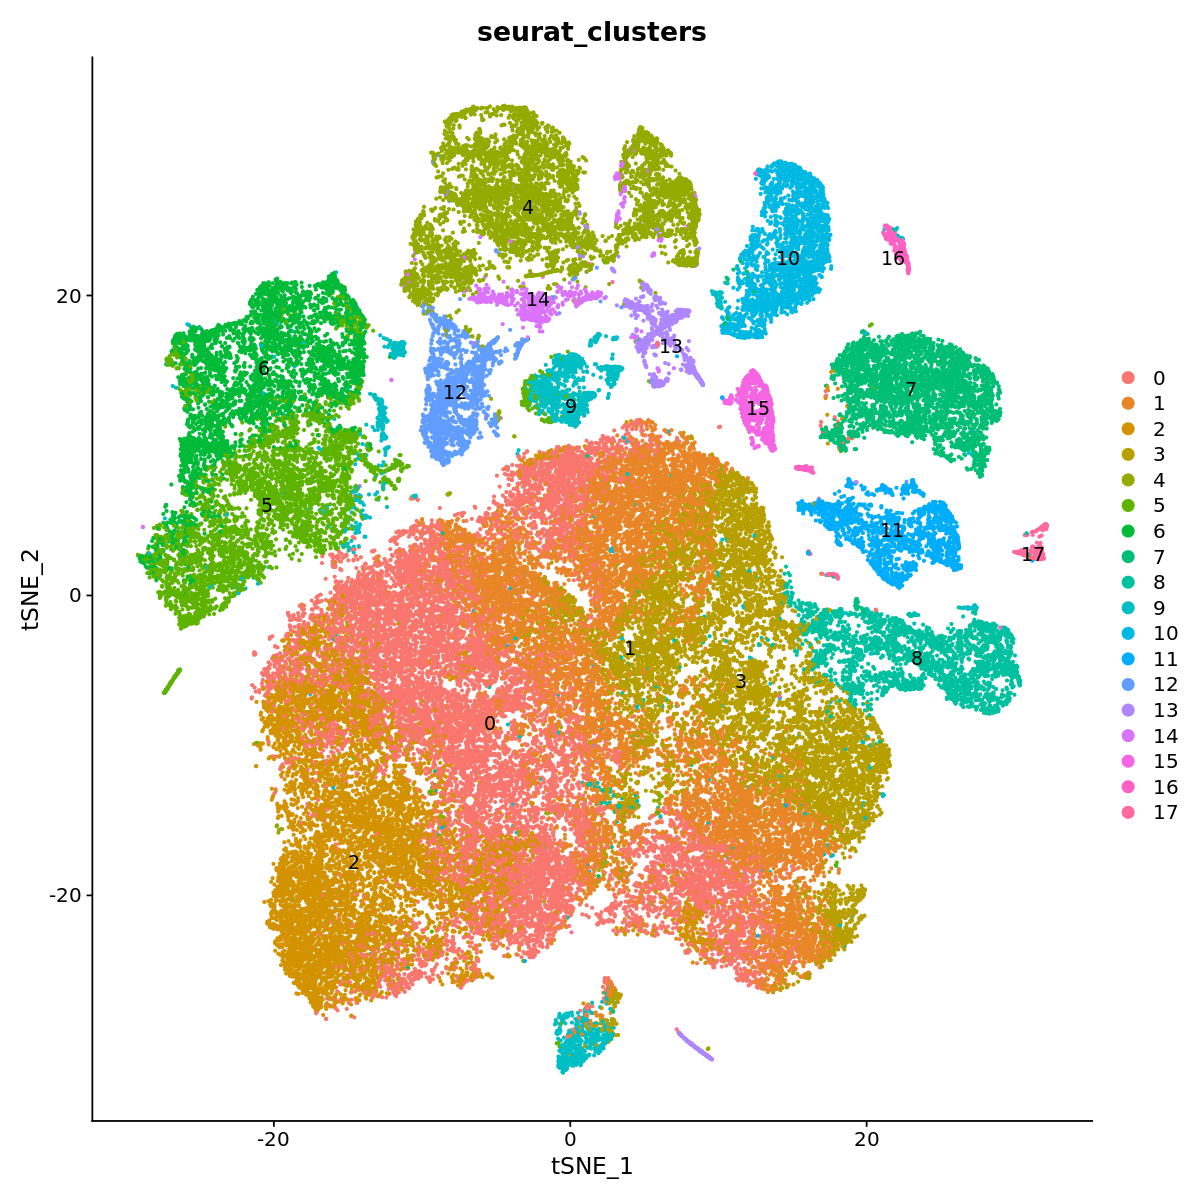

In [30]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(Exp_clust, reduction="tsne", label = TRUE, group.by='seurat_clusters',  pt.size = 0.5)

In [31]:
Exp_clust_umap <- FindNeighbors(Exp_integrated_umap, dims= 1:10)
Exp_clust_umap <- FindClusters(Exp_clust_umap, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 80000
Number of edges: 2270618

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9174
Number of communities: 18
Elapsed time: 30 seconds


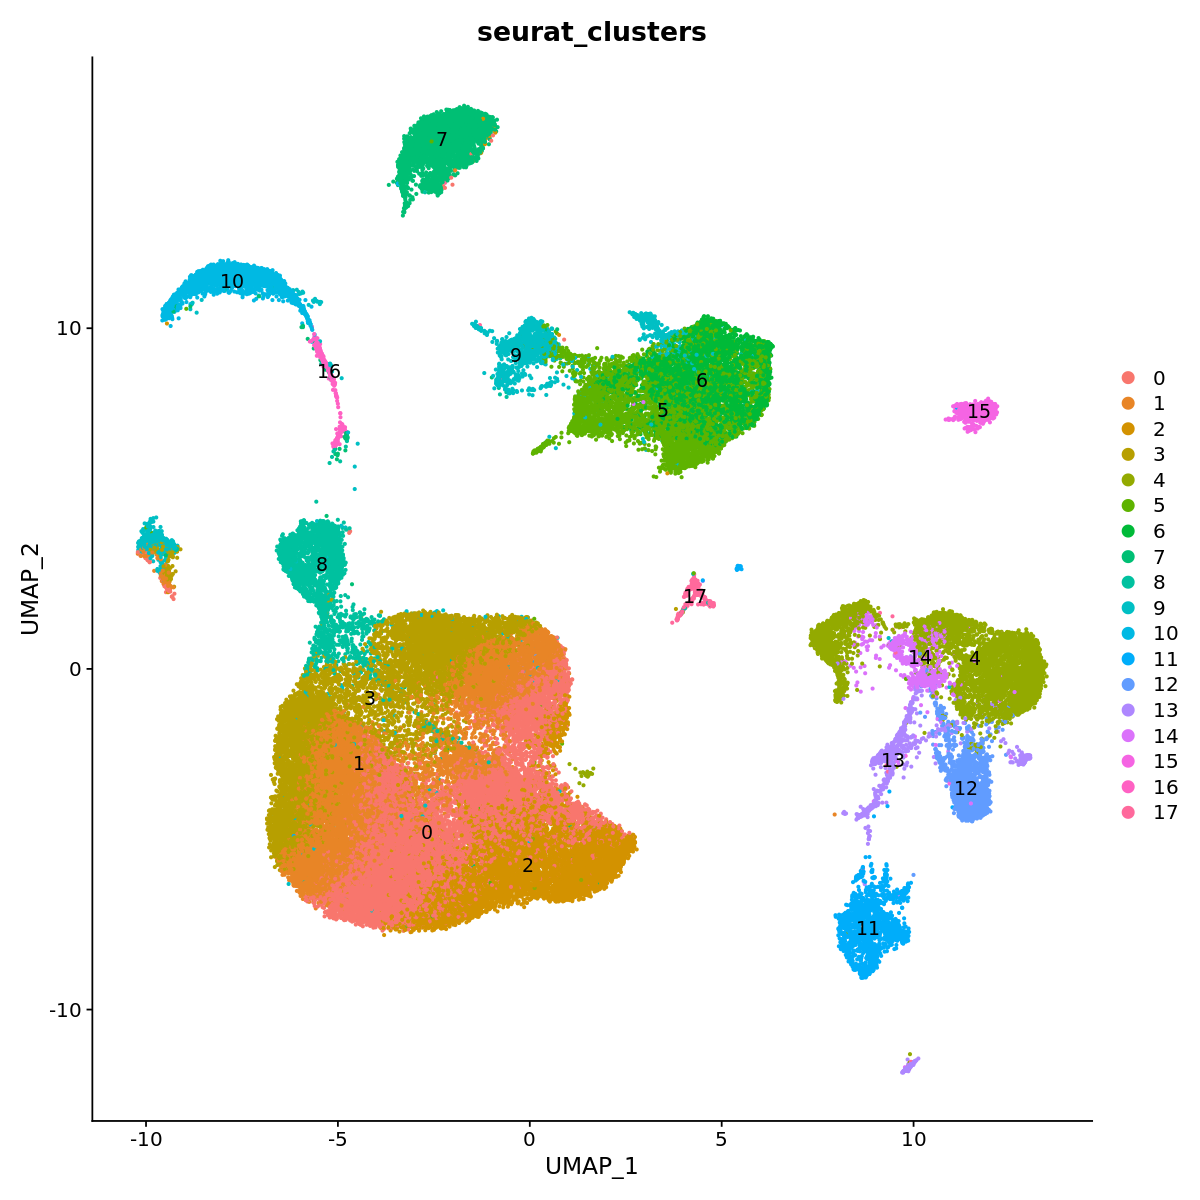

In [32]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(Exp_clust_umap, reduction="umap", label = TRUE, group.by='seurat_clusters',  pt.size = 0.5)

## Loading saved R objects 

In [1]:
# previously filtered Cd4+ r objects (filter = Cd4 > 0)

In [2]:
test <- readRDS(file='/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/final_cd4_filtered.rds')

In [8]:
test_umap <- readRDS(file='/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/final_cd4_filtered_UMAP.rds')

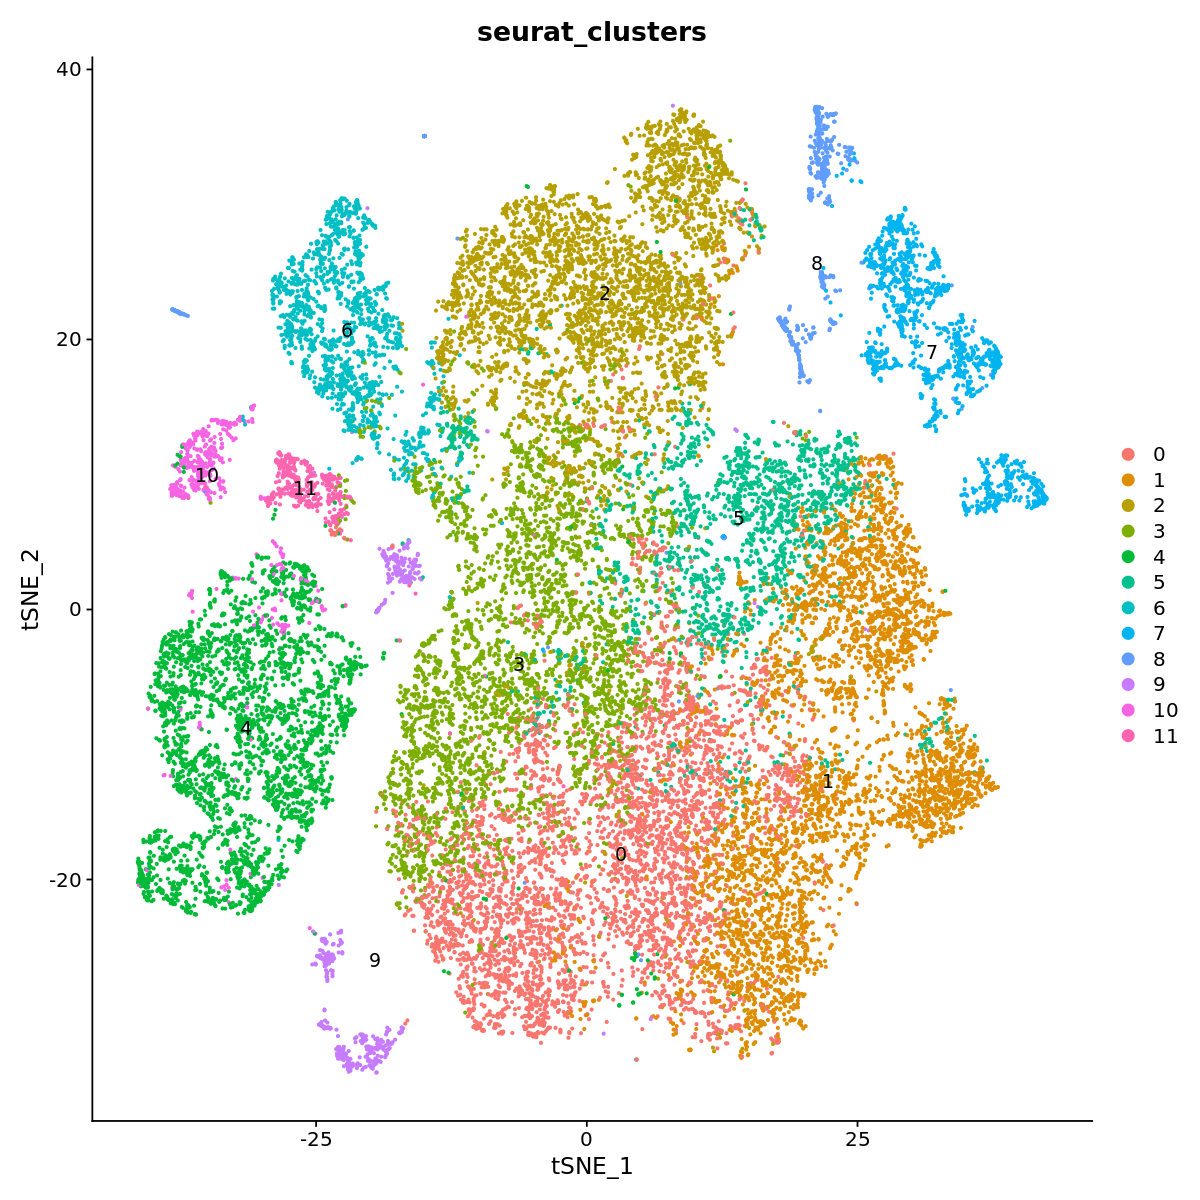

In [42]:
#plot tsne
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(test, reduction="tsne", label = TRUE, group.by='seurat_clusters',  pt.size = 0.5)

In [43]:
#subsetting clusters for individual use 
clust0 <- subset(test, ident=c('0'))
clust1 <- subset(test, ident=c('1'))
clust2 <- subset(test, ident=c('2'))
clust3 <- subset(test, ident=c('3'))
clust4 <- subset(test, ident=c('4'))
clust5 <- subset(test, ident=c('5'))
clust6 <- subset(test, ident=c('6'))
clust7 <- subset(test, ident=c('7'))
clust8 <- subset(test, ident=c('8'))
clust9 <- subset(test, ident=c('9'))
clust10 <- subset(test, ident=c('10'))
clust11 <- subset(test, ident=c('11'))

In [61]:
#write each cluster to excel sheet for barcodes 
write.xlsx(rownames(clust0@meta.data), file="all barcodes.xlsx", sheetName="cluster0 barcodes", row.names=TRUE)
write.xlsx(rownames(clust1@meta.data), file="all barcodes.xlsx", sheetName="cluster1 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust2@meta.data), file="all barcodes.xlsx", sheetName="cluster2 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust3@meta.data), file="all barcodes.xlsx", sheetName="cluster3 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust4@meta.data), file="all barcodes.xlsx", sheetName="cluster4 barcodes",append= TRUE,  row.names=TRUE)
write.xlsx(rownames(clust5@meta.data), file="all barcodes.xlsx", sheetName="cluster5 barcodes",append= TRUE,  row.names=TRUE)
write.xlsx(rownames(clust6@meta.data), file="all barcodes.xlsx", sheetName="cluster6 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust7@meta.data), file="all barcodes.xlsx", sheetName="cluster7 barcodes",append= TRUE,  row.names=TRUE)
write.xlsx(rownames(clust8@meta.data), file="all barcodes.xlsx", sheetName="cluster8 barcodes",append= TRUE,  row.names=TRUE)
write.xlsx(rownames(clust9@meta.data), file="all barcodes.xlsx", sheetName="cluster9 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust10@meta.data), file="all barcodes.xlsx", sheetName="cluster10 barcodes", append= TRUE, row.names=TRUE)
write.xlsx(rownames(clust11@meta.data), file="all barcodes.xlsx", sheetName="cluster11 barcodes", append= TRUE, row.names=TRUE)


In [14]:
library(RColorBrewer)
brewer.pal(n=12,"Set1")

Warning message in brewer.pal(n = 12, "Set1"):
"n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
"


[1] "#E41A1C" "#377EB8" "#4DAF4A" "#984EA3" "#FF7F00" "#FFFF33" "#A65628"
[8] "#F781BF" "#999999"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



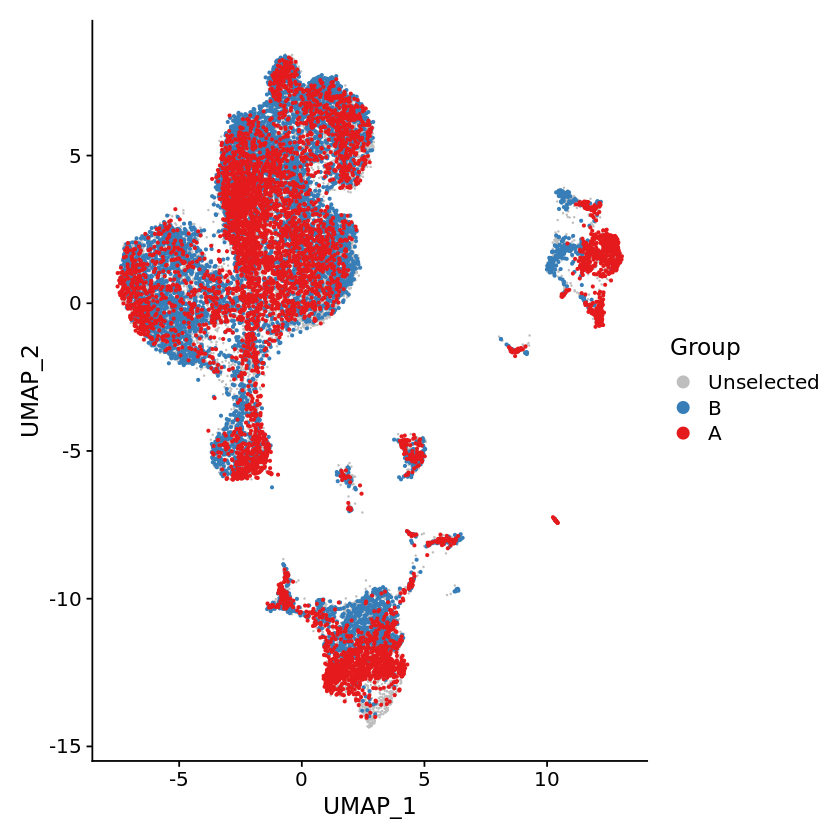

In [15]:
#plotting by specified groups A and B
gA <- WhichCells(test_umap, idents = c("A"))
gB <- WhichCells(test_umap, idents = c("B"))
DimPlot(test_umap, label=F, cells.highlight= list(gA, gB), cols.highlight = c('#377EB8', '#E41A1C'), cols= "grey",sizes.highlight = 0.5) +
scale_color_manual(labels = c("Unselected","B", "A"), values = c("grey", '#377EB8', '#E41A1C')) +
  labs(color = "Group")

#blue- B
#red - A

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



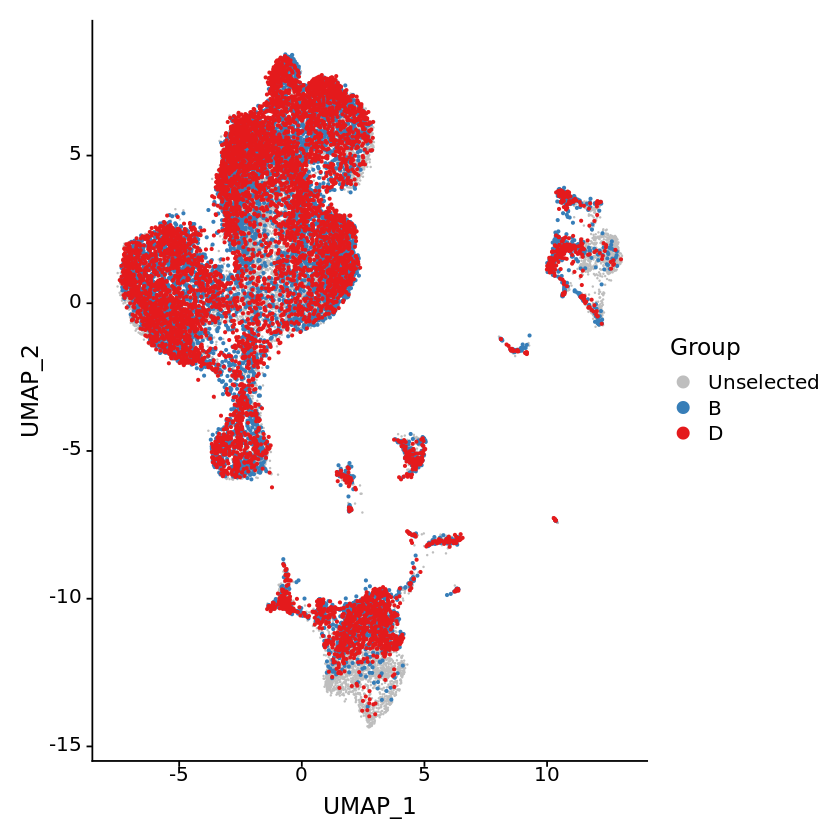

In [16]:
#plotting by groups B and D 
gA <- WhichCells(test_umap, idents = c("B"))
gB <- WhichCells(test_umap, idents = c("D"))
DimPlot(test_umap, label=F, cells.highlight= list(gA, gB), cols.highlight = c('#377EB8', '#E41A1C'), cols= "grey",sizes.highlight = 0.5) +
scale_color_manual(labels = c("Unselected","B", "D"), values = c("grey", '#377EB8', '#E41A1C')) +
  labs(color = "Group")


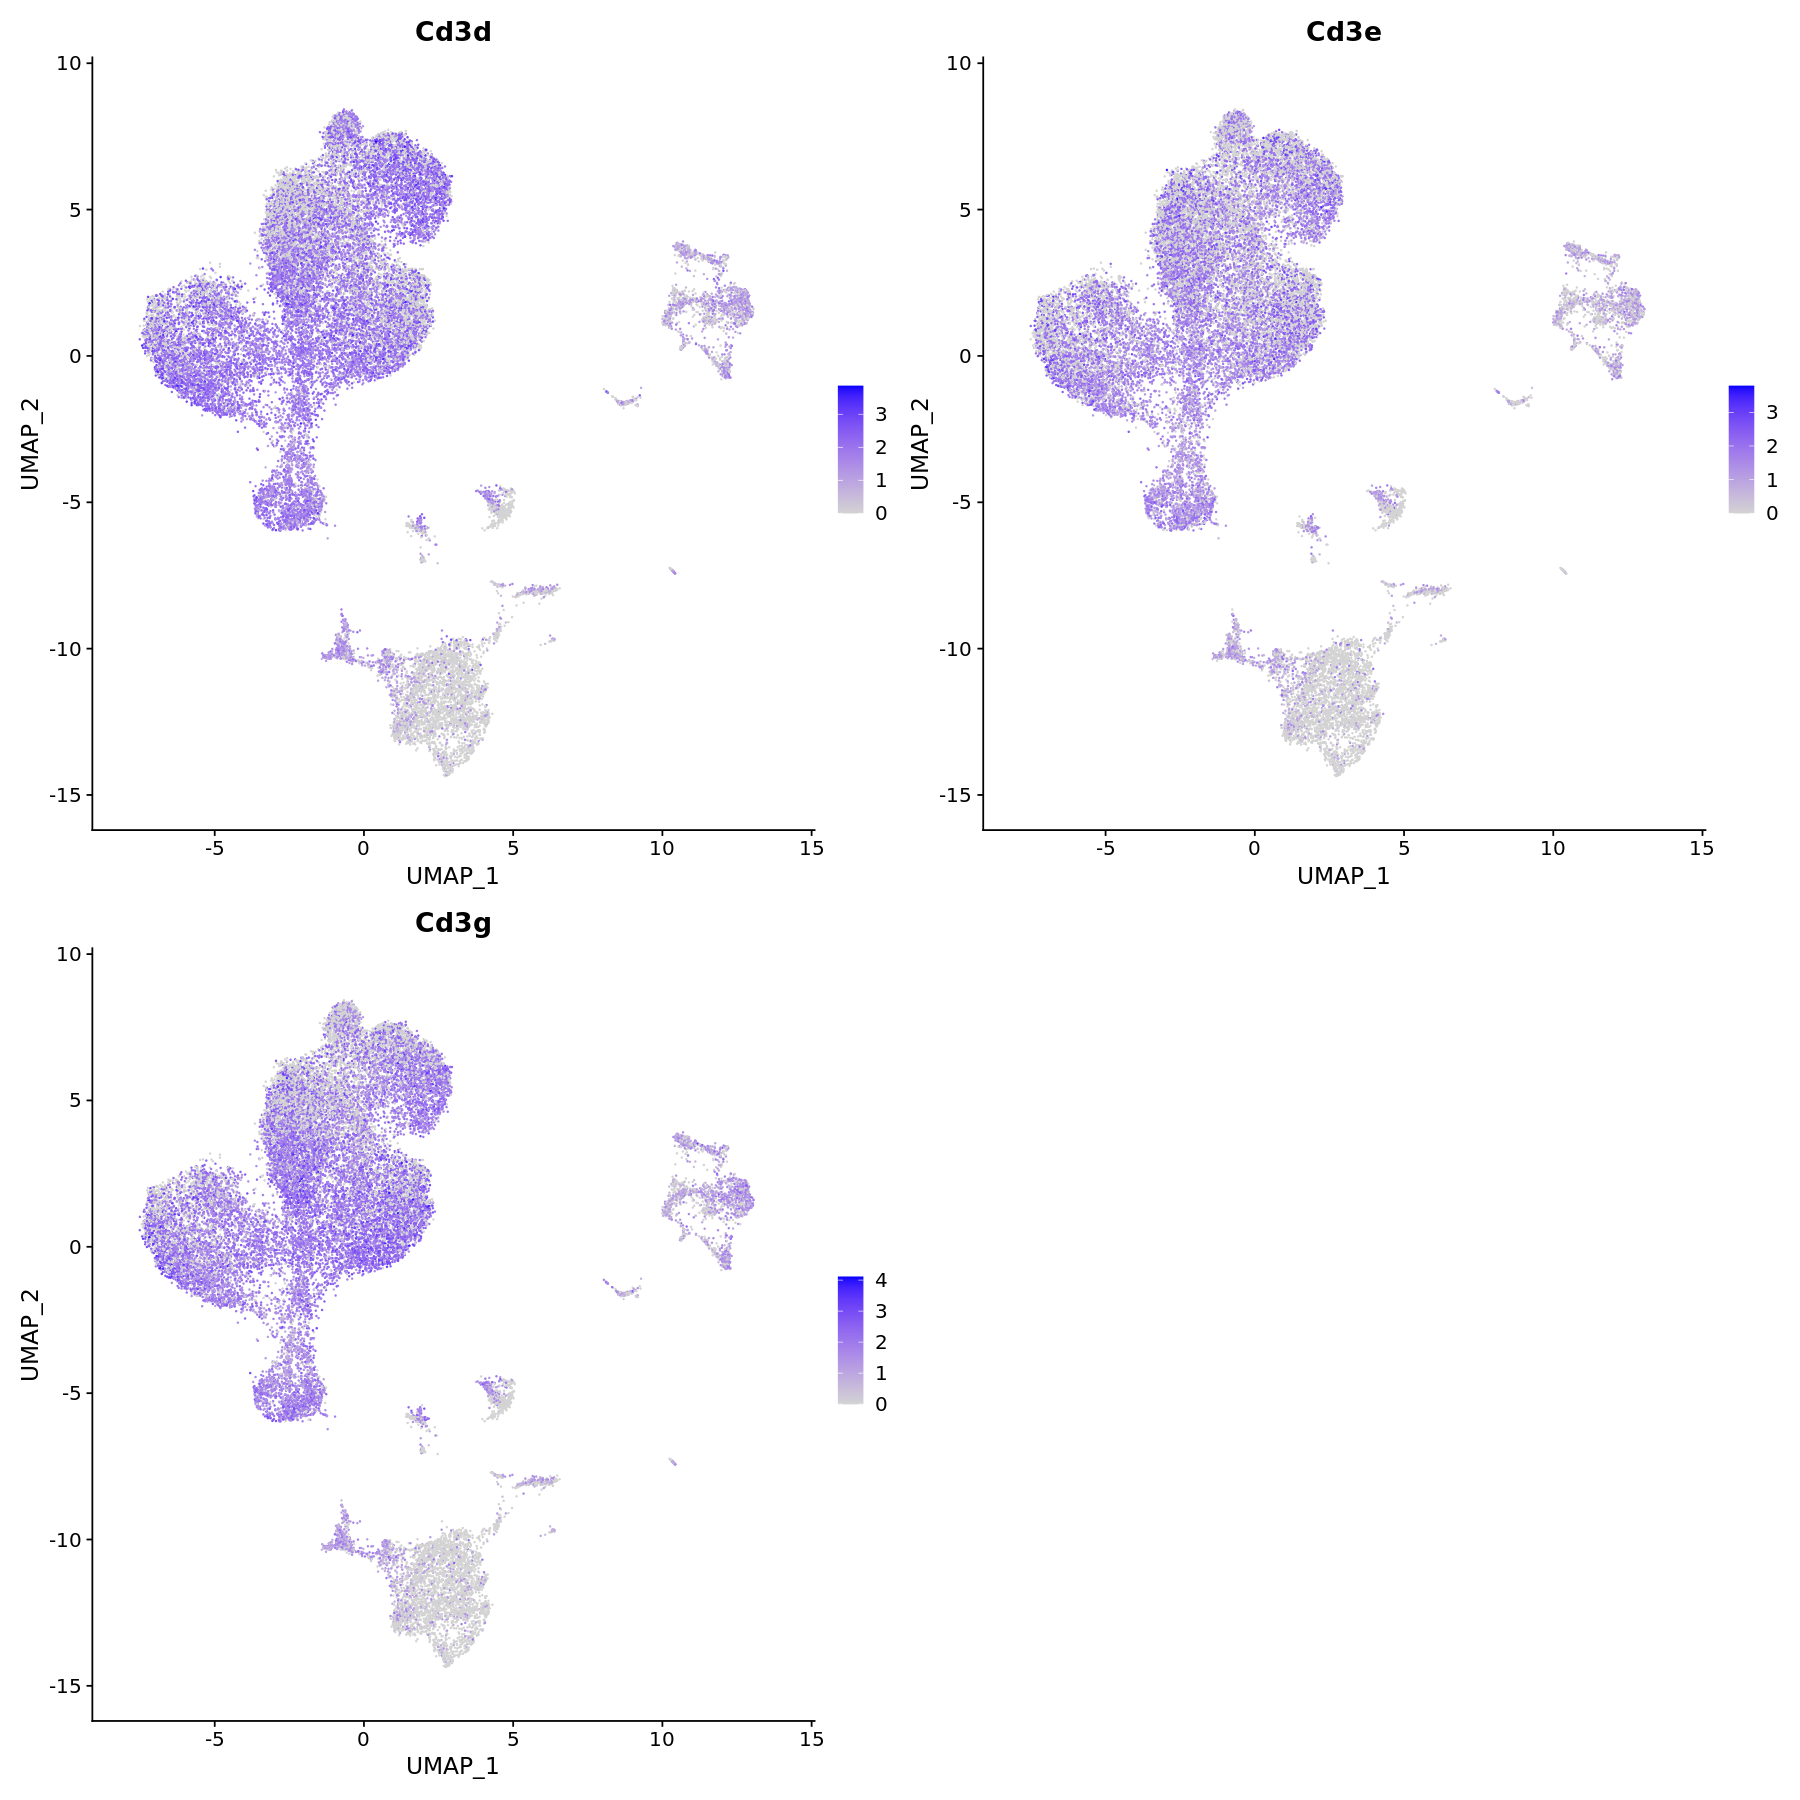

In [106]:
options(repr.plot.width = 15, repr.plot.height = 15)
FeaturePlot(test_umap, features=c('Cd3d', 'Cd3e','Cd3g'))

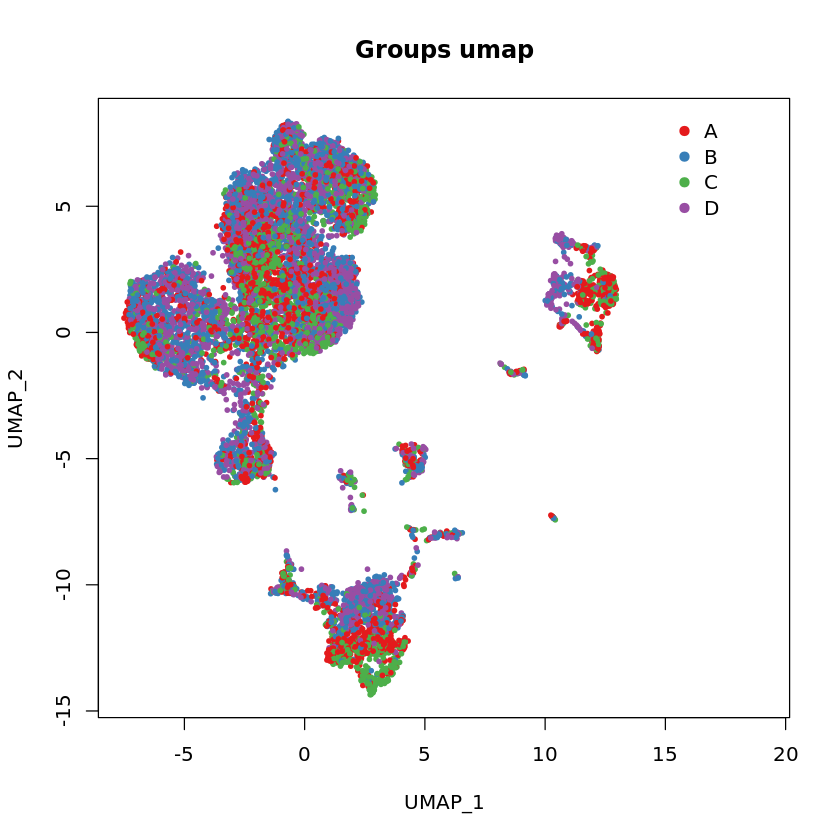

In [19]:
plotByUMAPGroup(test_umap,Group_assignment=test_umap@meta.data$letter.ids,main="Groups") #batchs

In [45]:
# plotting for proportion of samples per cluster
pt <- table(Idents(test), test$seurat_clusters)
pt <- as.data.frame(pt)
pt$Var1 <- as.character(pt$Var1)

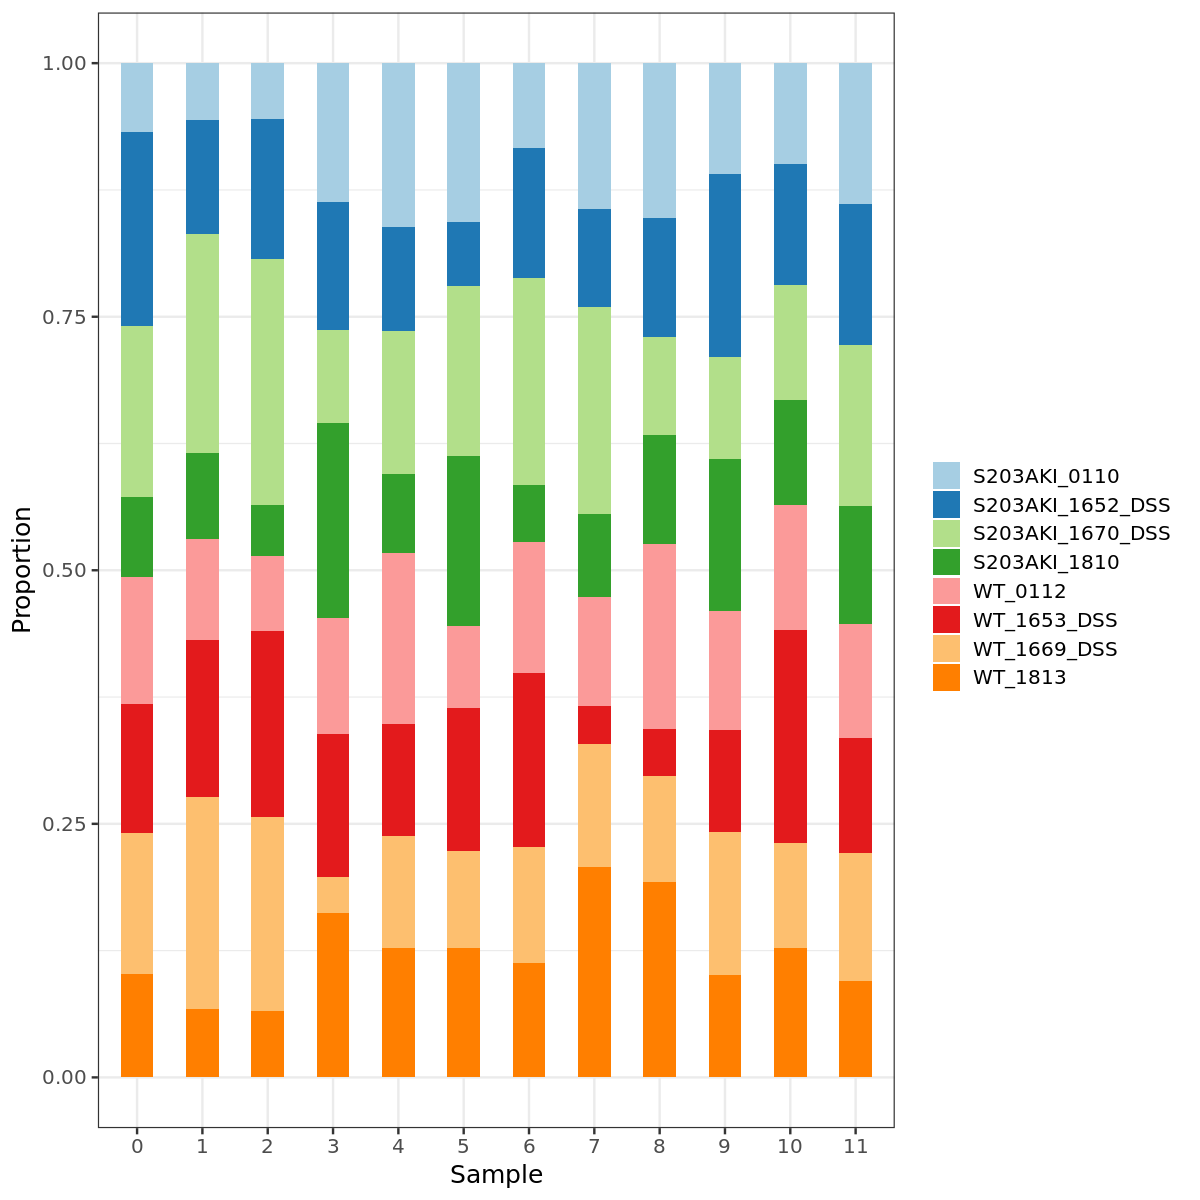

In [46]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(pt, aes(x = Var2, y = Freq, fill = Var1)) +
  theme_bw(base_size = 15) +
  geom_col(position = "fill", width = 0.5) +
  xlab("Sample") +
  ylab("Proportion") +
  scale_fill_manual(values = brewer.pal(12, "Paired")) +
  theme(legend.title = element_blank())

In [48]:
# plotting for proportion of samples per paired gorup sample
pt <- table(Idents(test), test$seurat_clusters)
pt <- as.data.frame(pt)
pt$Var1 <- as.character(pt$Var1)



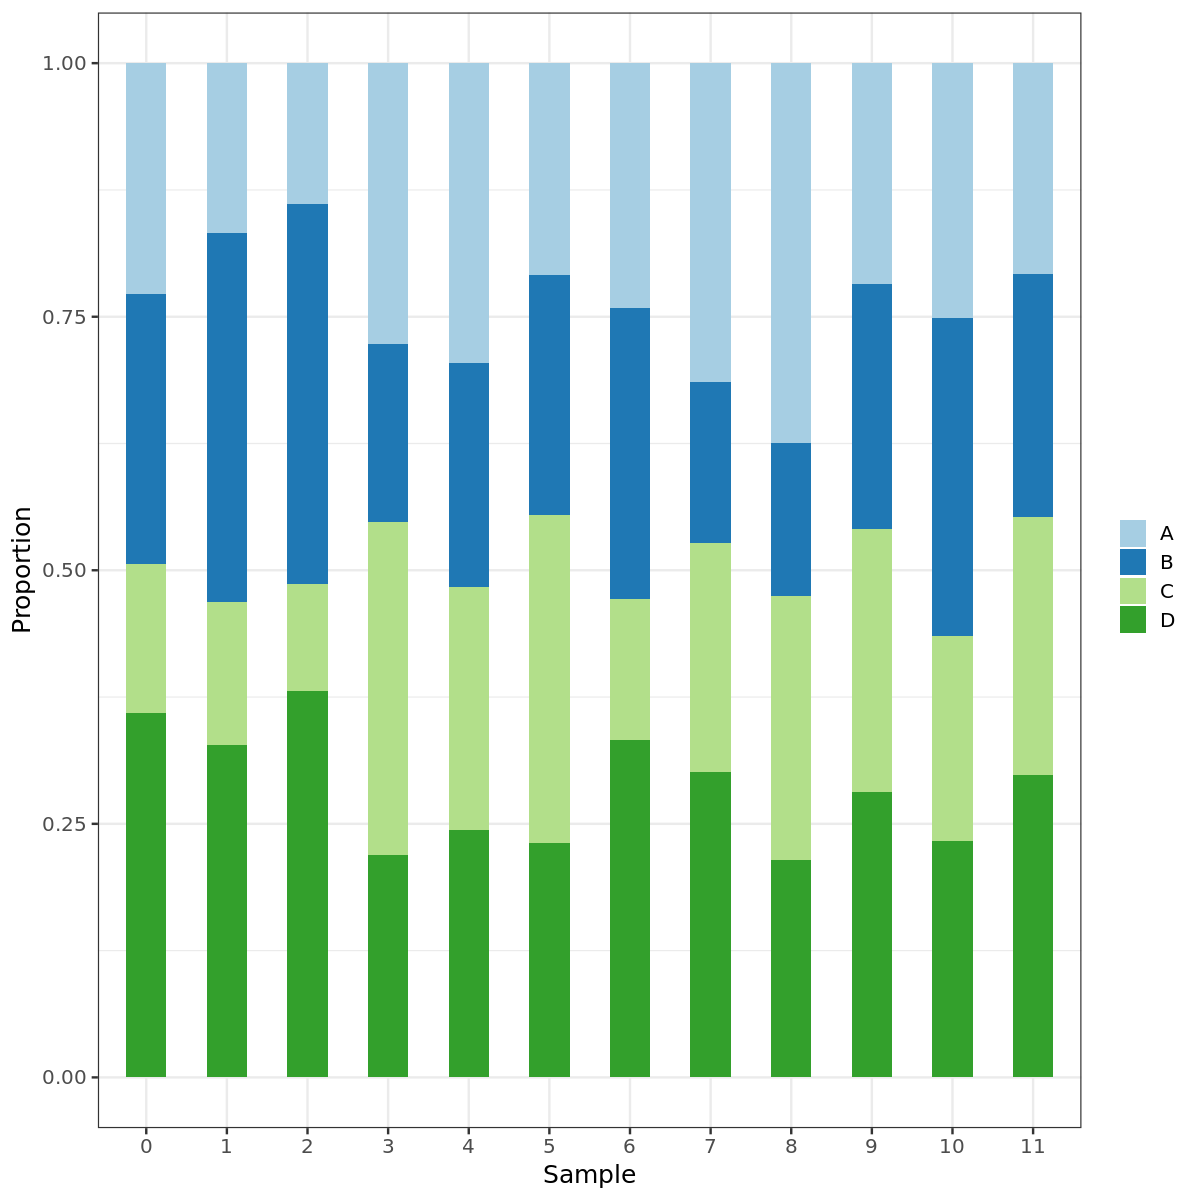

In [49]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(pt, aes(x = Var2, y = Freq, fill = Var1)) +
  theme_bw(base_size = 15) +
  geom_col(position = "fill", width = 0.5) +
  xlab("Sample") +
  ylab("Proportion") +
  scale_fill_manual(values = brewer.pal(12, "Paired")) +
  theme(legend.title = element_blank())

In [5]:
#making function for modified stacked violin plot
library(Seurat)
library(patchwork)
library(ggplot2)

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}


Attaching package: 'patchwork'


The following object is masked from 'package:cowplot':

    align_plots




In [8]:
test2 <- subset(test, idents=c('0','3','2','5','1','6'))

In [11]:
my_levels <- c('6','1','5','2','3','0')

# Relevel object@ident
Idents(test2) <- factor(x = Idents(test2), levels = my_levels)

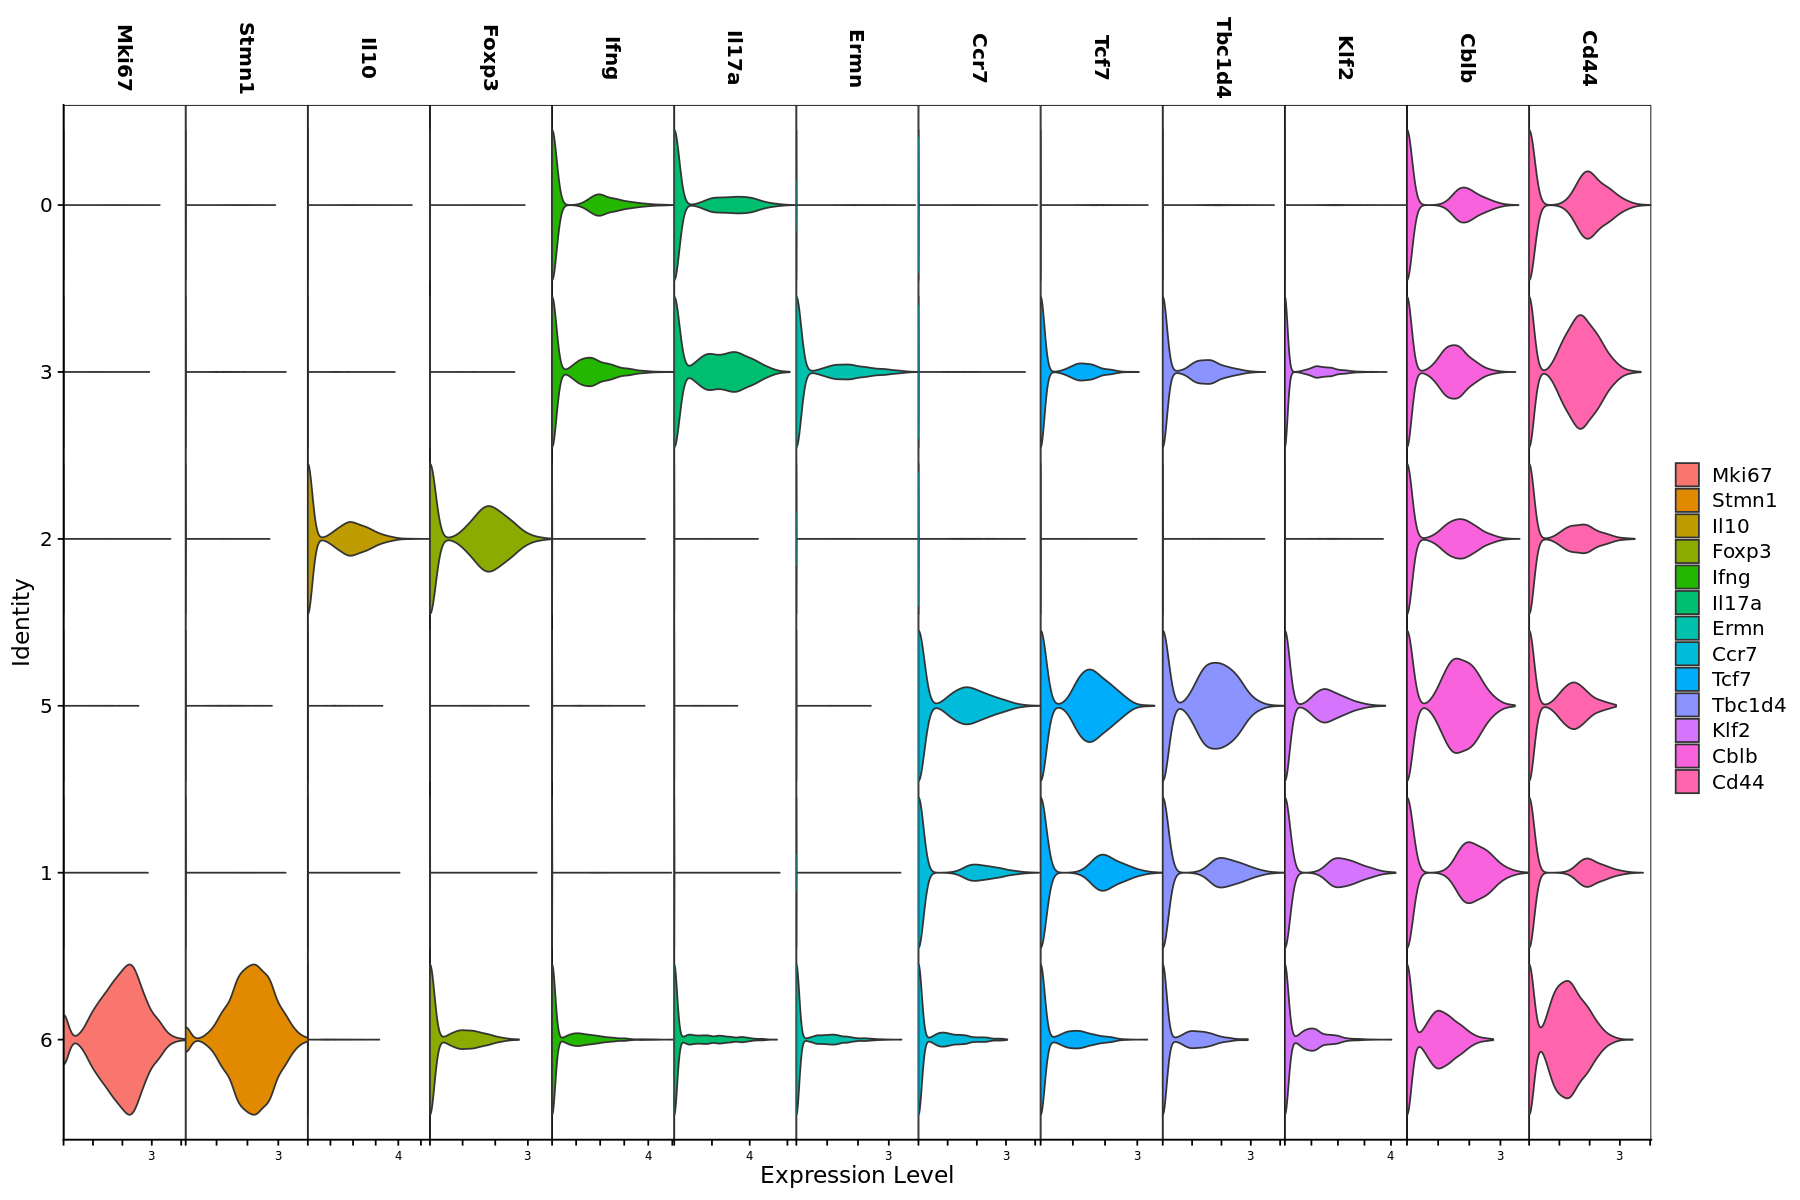

In [12]:
features<- c('Mki67','Stmn1','Il10','Foxp3','Ifng','Il17a','Ermn','Ccr7','Tcf7','Tbc1d4','Klf2','Cblb','Cd44')
options(repr.plot.width = 15, repr.plot.height = 10)
#VlnPlot(obj = test, features = features, ncol=1, pt.size =0.1)
VlnPlot(obj = test2, features = features,stack=TRUE)

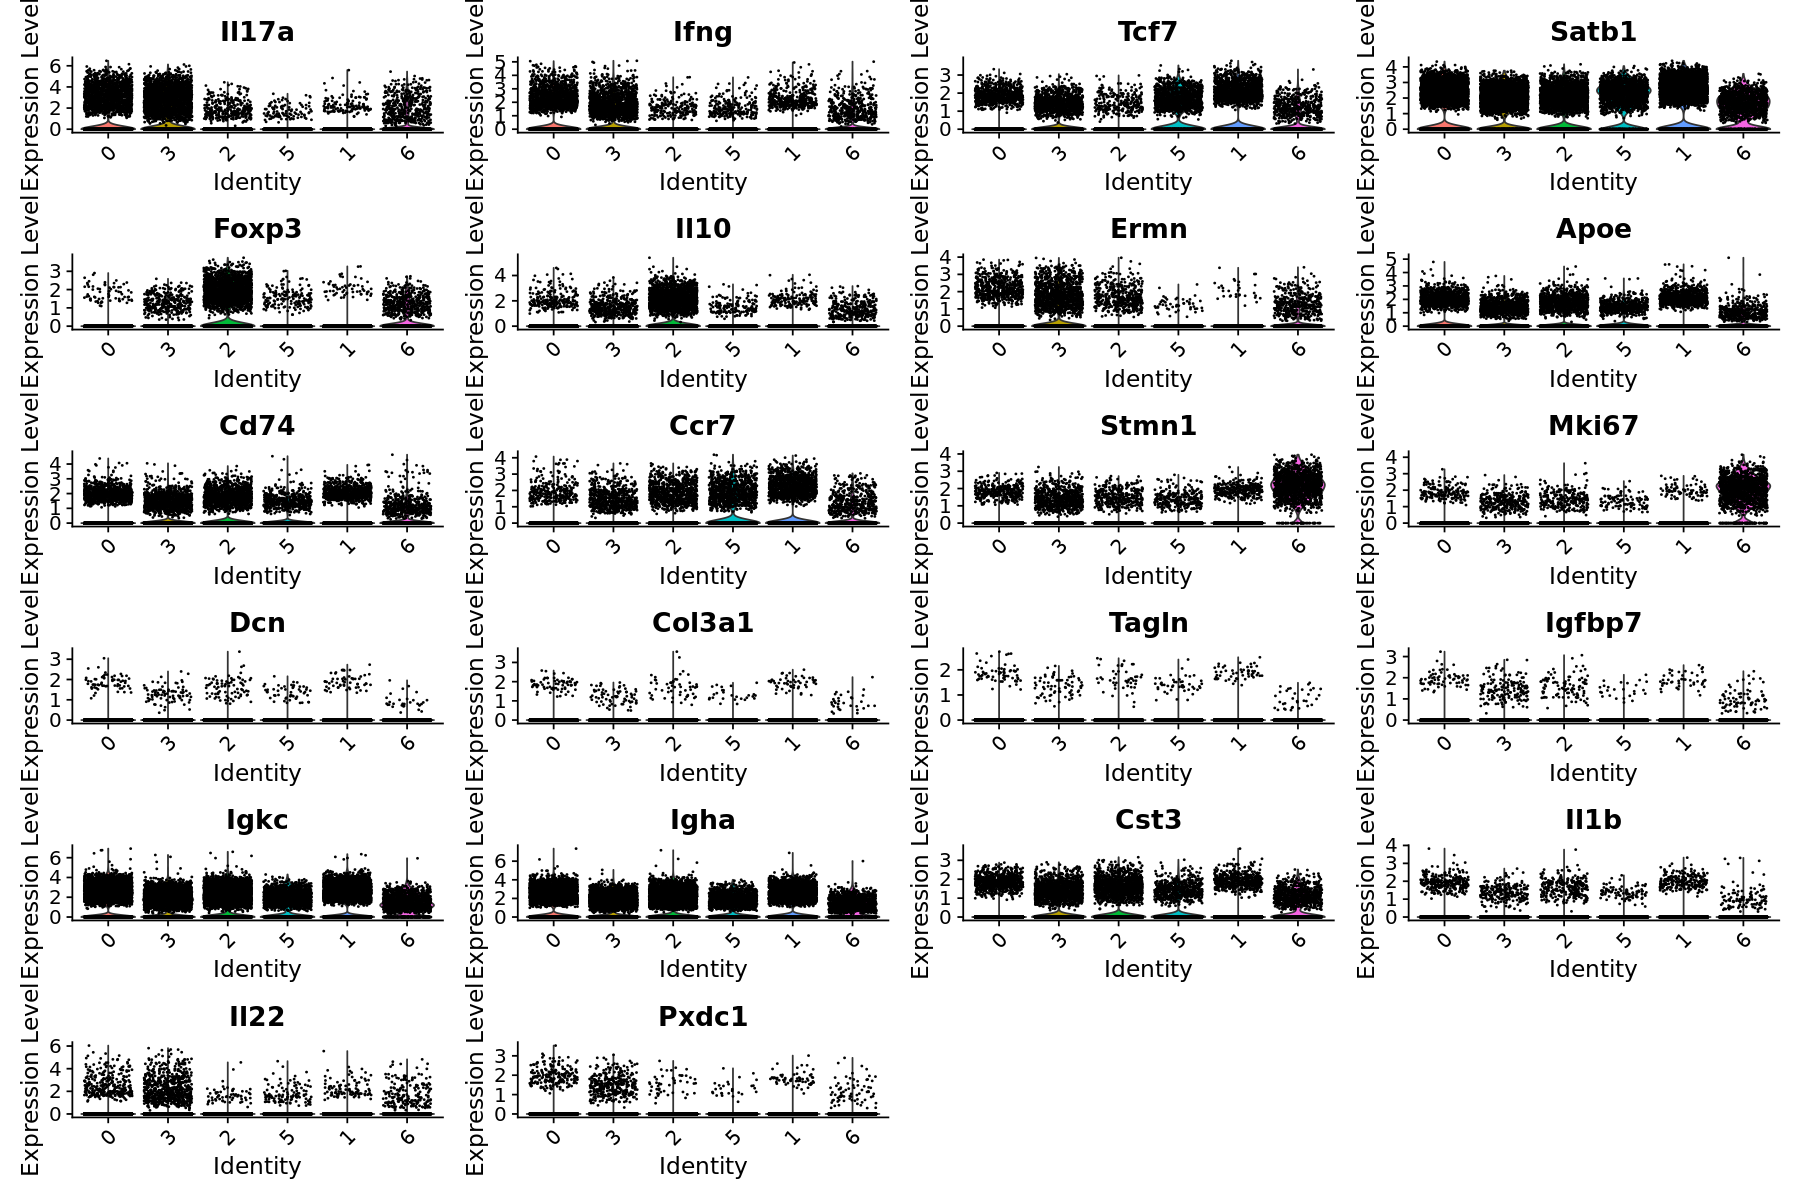

In [46]:
features<- c('Il17a','Ifng','Tcf7','Satb1','Foxp3','Il10','Ermn','Apoe','Cd74','Ccr7',
            'Stmn1','Mki67','Dcn','Col3a1','Tagln','Igfbp7','Igkc','Igha','Cst3','Il1b','Il22','Pxdc1')
options(repr.plot.width = 15, repr.plot.height = 10)
#VlnPlot(obj = test, features = features, ncol=1, pt.size =0.1)
VlnPlot(obj = test2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', 

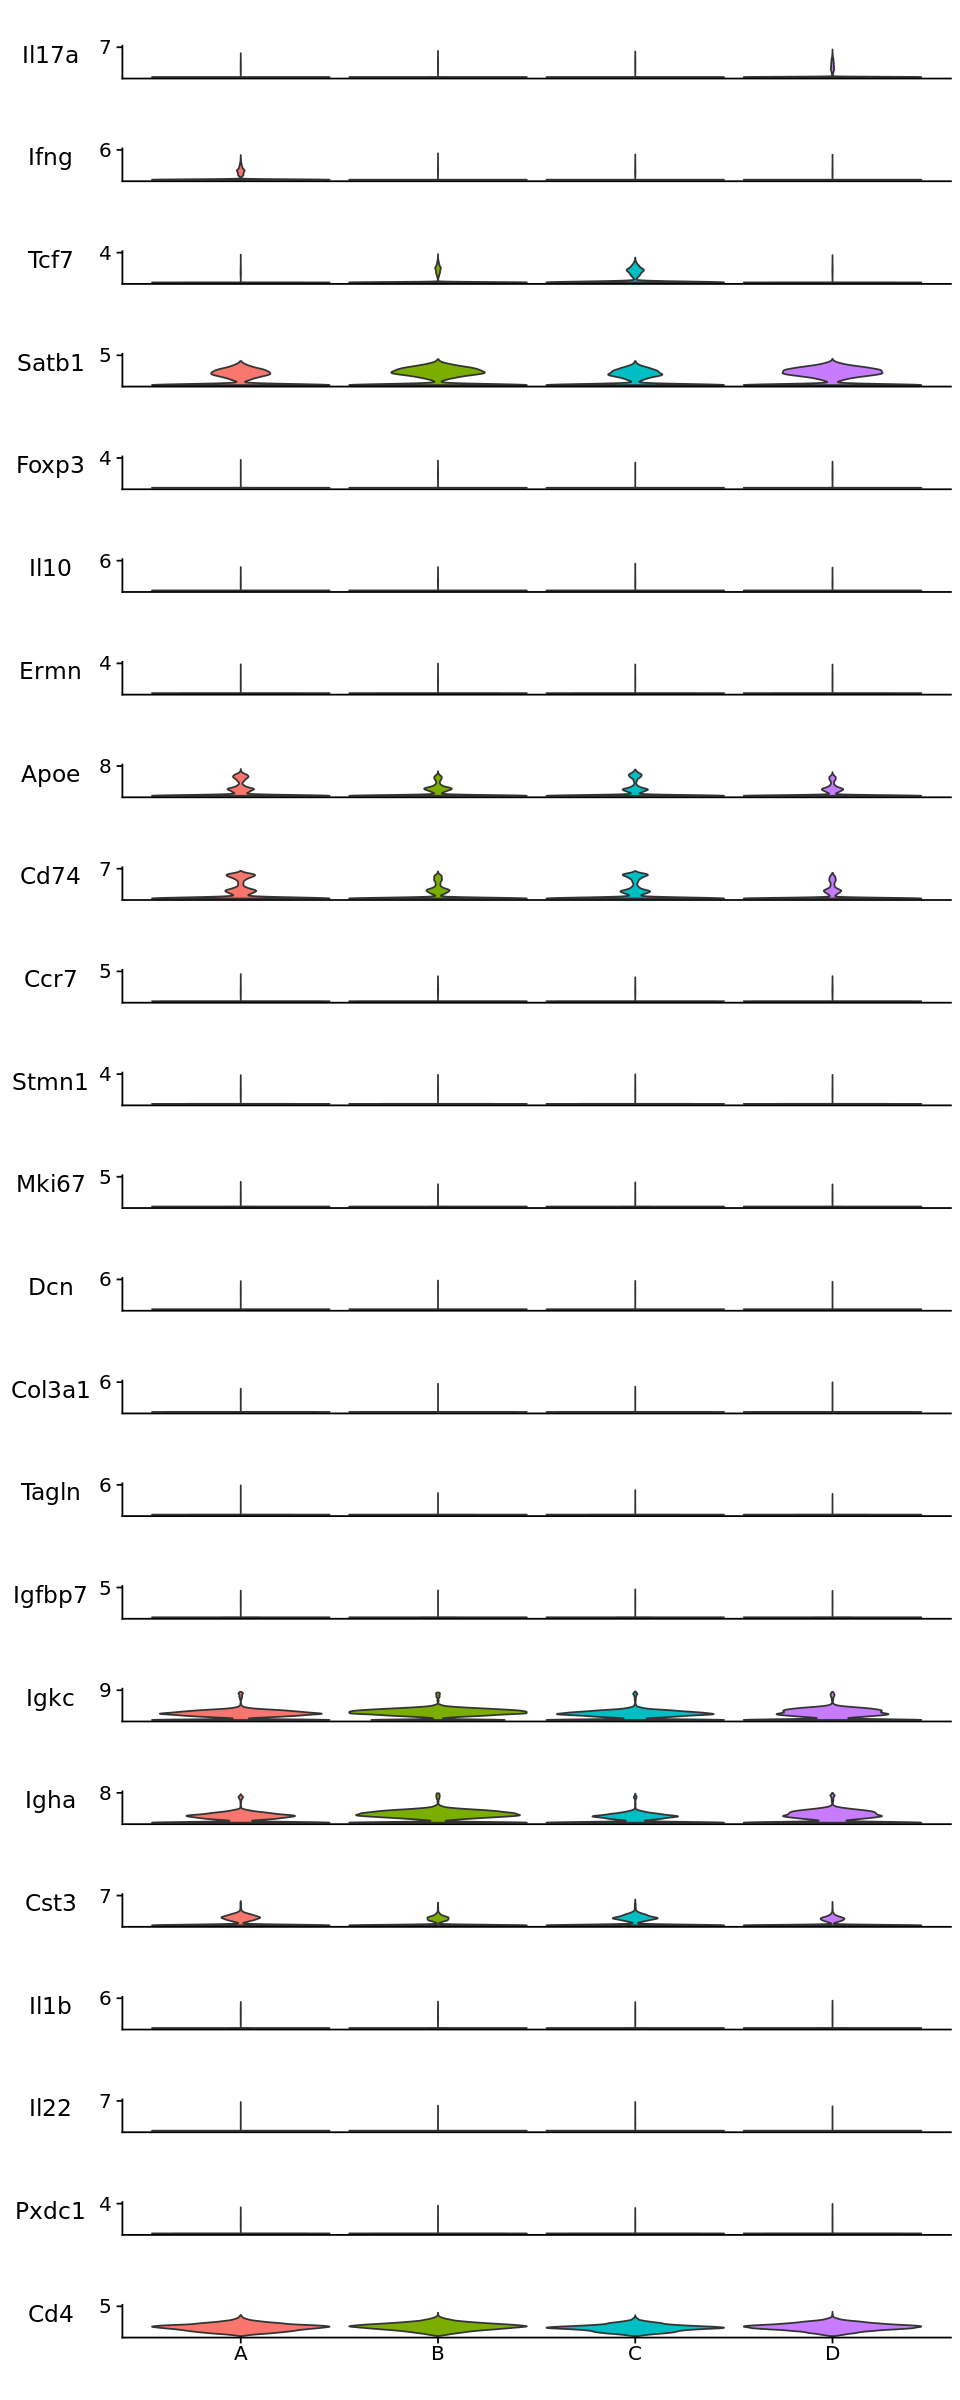

In [6]:
features<- c('Il17a','Ifng','Tcf7','Satb1','Foxp3','Il10','Ermn','Apoe','Cd74','Ccr7',
            'Stmn1','Mki67','Dcn','Col3a1','Tagln','Igfbp7','Igkc','Igha','Cst3','Il1b','Il22','Pxdc1','Cd4')
options(repr.plot.width = 8, repr.plot.height = 20)
StackedVlnPlot(obj = test, features = features)

In [ ]:
#violin plot (Focus on Cluster 2, 0, 3)
#(1 graph for 1 gene)
#S1pr4 (Lymphatic migration)
#Ccr7 (traffic in/out intestine)
#Foxp3
#Rorc
#Il17a
#Il1r2
#Rps26 (ribosome metabolism)
#Rps28 (ribosome metabolism)
#Med13 (mediator complex)

#X axis category: Cluster 2 (A_C_B_D), Cluster 0 (A_C_B_D), 3 (A_C_B_D)


In [27]:
fig1 <- subset(test, idents=c('0','2','3'))

In [ ]:
features<- c('S1pr4','Ccr7','Foxp3','Rorc','Il17a','Il1r2','Rps26','Rps28','Med13')
options(repr.plot.width = 8, repr.plot.height = 30)

VlnPlot(obj = fig1,split.by="letter.ids", split.plot=TRUE, features = features, 
        ncol=1, pt.size =0.1,combine=TRUE) + theme(legend.position = 'right')

In [ ]:
fig2 <- subset(test, idents=c('4','8','11'))

In [ ]:
features<- c('Adgre1','Il10','Foxp3','Lyve1','Rorc','Il17a','Pxdc1','Il22')

options(repr.plot.width = 8, repr.plot.height = 25)

VlnPlot(obj = fig2,split.by="letter.ids", split.plot=TRUE, features = features, 
        ncol=1, pt.size =0.1,combine=TRUE) + theme(legend.position = 'right')

In [ ]:
#violin plot (Focus on Cluster 4, 8, 11)
#(1 graph for 1 gene)
#Adgre1 (F4/80 Mac marker) 
#Il10
#Foxp3
#Lyve1 (LEC marker)
#Rorc
#Il17a
#Pxdc1 (ILC marker)
#IL22


In [ ]:
#Can we have 16 UMAP panels featuring specific genes (Il17a, Il10, Areg, and Il22),
#with 4 separate windows for each gene to feature expression from A, B, C, and D samples?

#Forgot to mention it would be great if you can try further subdividing 
#cluster 2 and see if there are any genes in the subclusters with differential 
#expression DE patterns in AvsC and BvsD. Thank you!
 

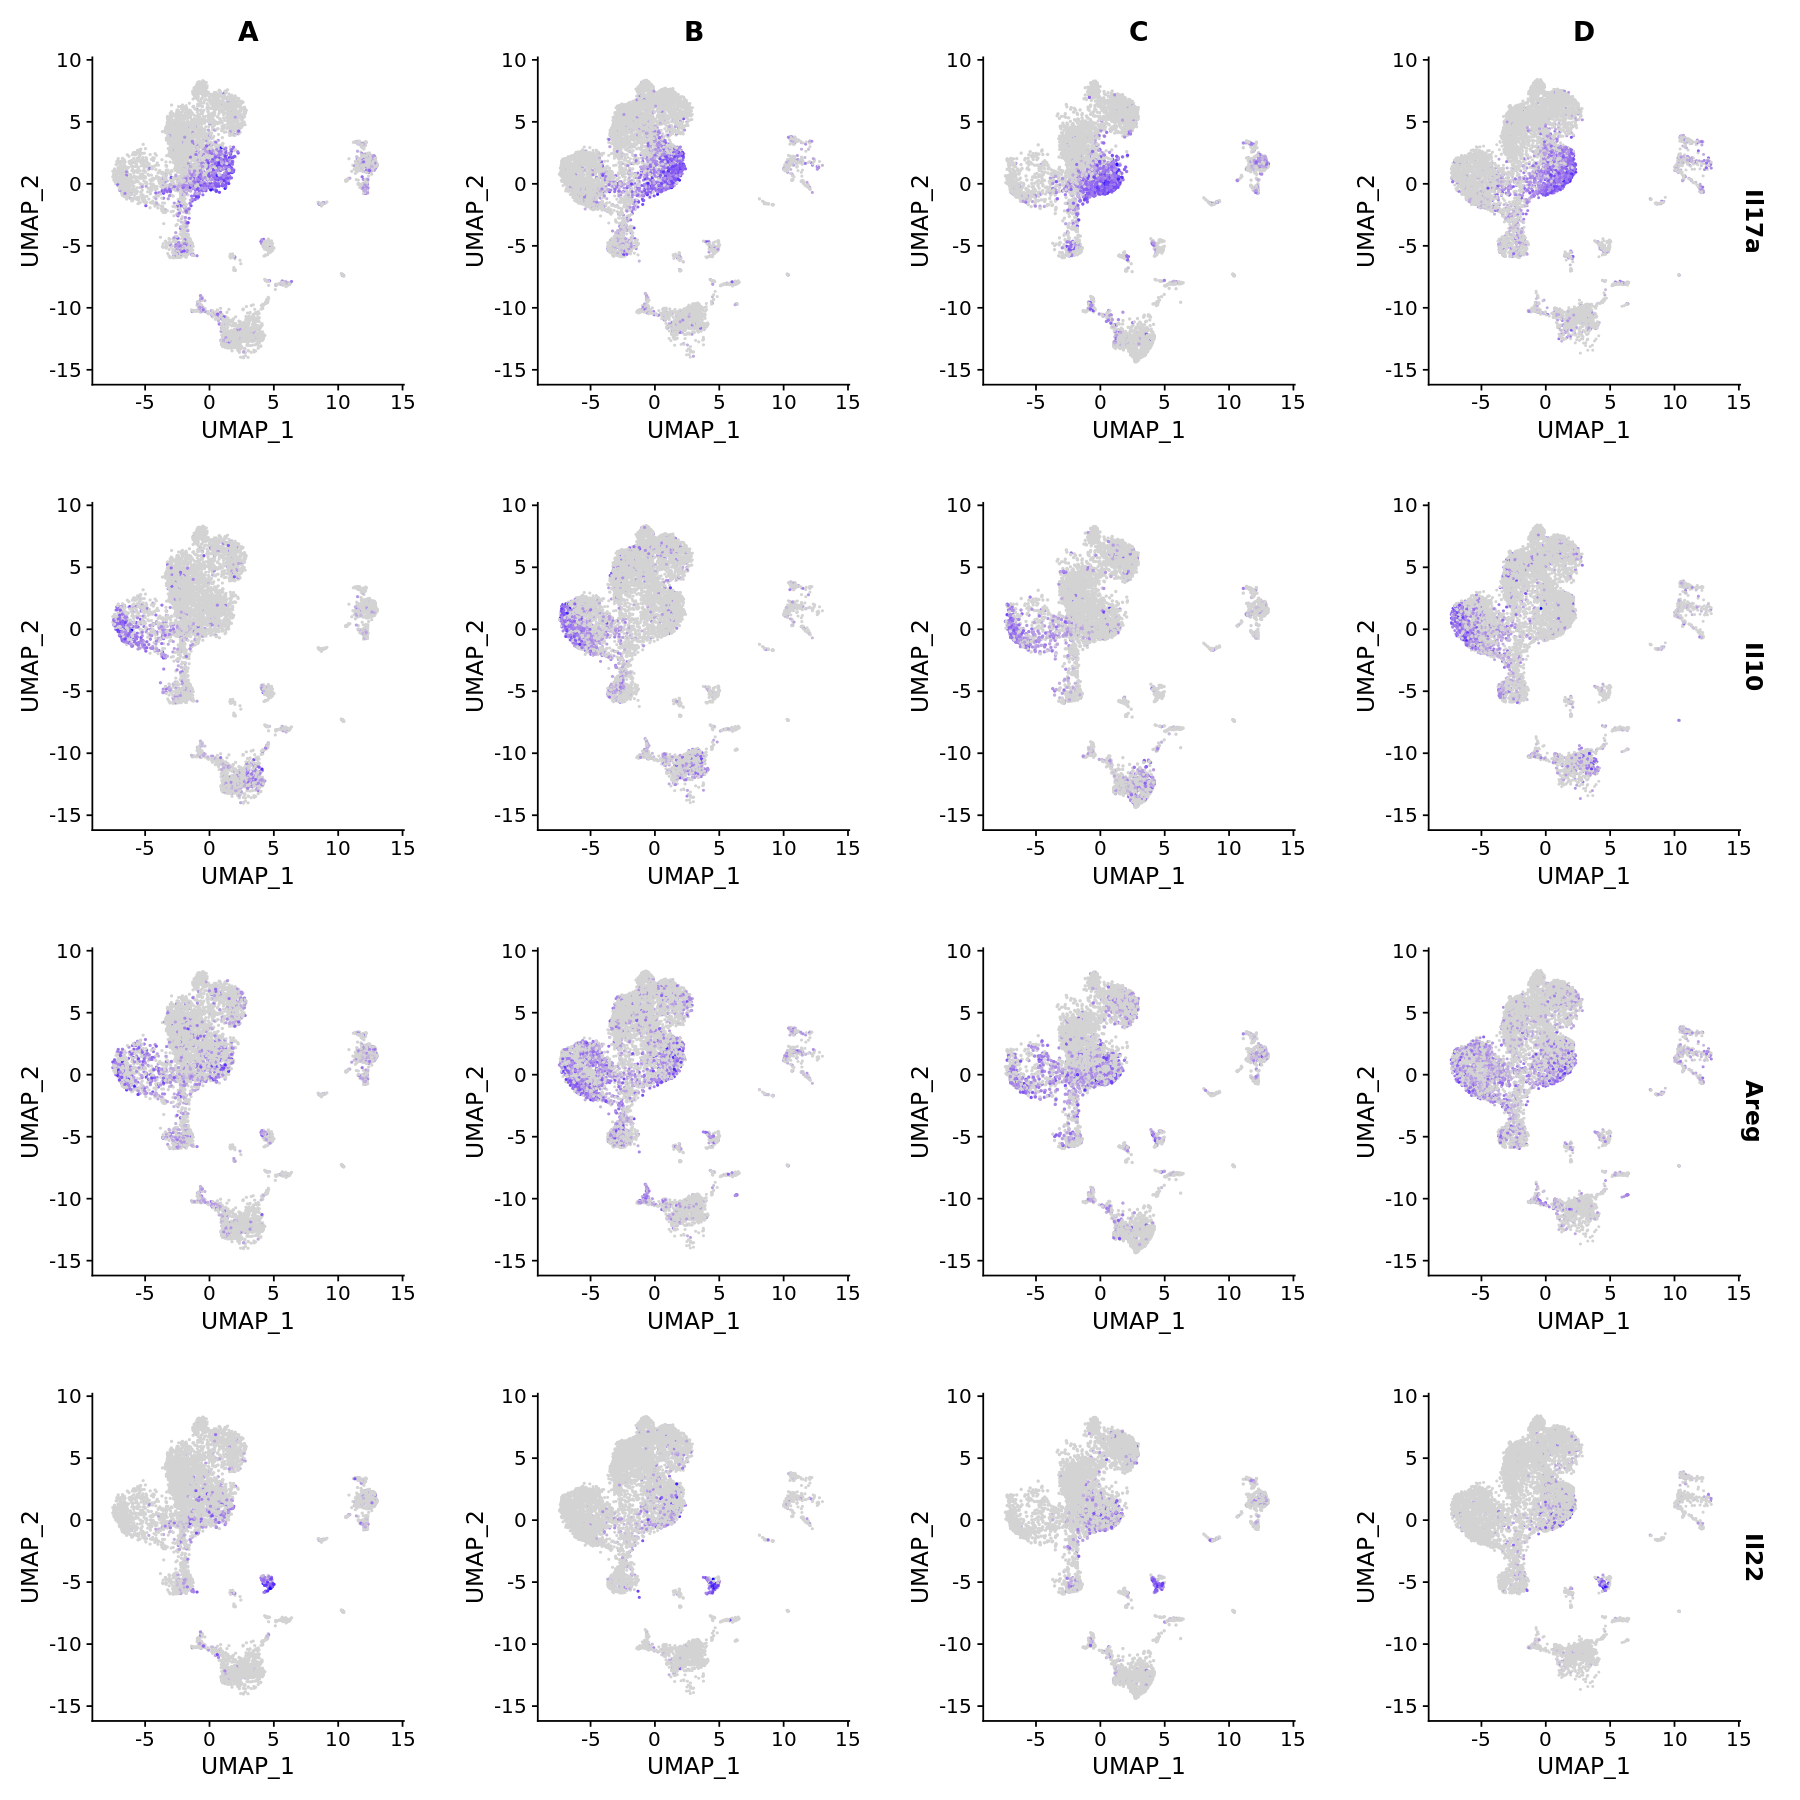

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)
FeaturePlot(test_umap, features=c('Il17a','Il10','Areg','Il22'), split.by='letter.ids')

In [45]:
test$seurat_clusters -> Idents(test)
clust2 <- subset(test, idents='2')
clust2

In [48]:
Exp_integrated <- clust2

In [49]:
DefaultAssay(clust2) <- "RNA"
clust2 <- FindVariableFeatures(object = clust2, selection.method = "vst", 
        nfeatures = 3000, verbose = FALSE)


In [50]:
clust2@assays$RNA@data=as.matrix(clust2@assays$RNA@data)

In [51]:
clust2 <- ScaleData(object = clust2, verbose = FALSE)

In [52]:
rna_idx=grep('\\|',rownames(clust2@assays$RNA@scale.data))
rna_scale=nrow(clust2@assays$RNA@scale.data)/length(rna_idx)*0.1
clust2@assays$RNA@scale.data[rna_idx,]=clust2@assays$RNA@scale.data[rna_idx,]*rna_scale

In [53]:
Exp_feature_names <- rownames(clust2@assays$RNA)

In [54]:
clust2 <- RunPCA(object = clust2, npcs = 30, verbose = FALSE, features = Exp_feature_names)

In [55]:
protein_idx=grep('\\|',rownames(clust2@assays$RNA@scale.data))
protein_scale=nrow(clust2@assays$RNA@scale.data)/length(protein_idx)*0.1
clust2@assays$RNA@scale.data[protein_idx,]=clust2@assays$RNA@scale.data[protein_idx,]*protein_scale

In [56]:
clust2_tsne <- RunTSNE(object = clust2, reduction = "pca", set.seed = 123, check_duplicates= FALSE, dims = 1:30)
clust2_umap <- RunUMAP(object = clust2, reduction = "pca", set.seed = 123, dims = 1:30)

Warning message:
"The following arguments are not used: set.seed"
11:40:28 UMAP embedding parameters a = 0.9922 b = 1.112

11:40:28 Read 4036 rows and found 30 numeric columns

11:40:28 Using Annoy for neighbor search, n_neighbors = 30

11:40:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:40:29 Writing NN index file to temp file /scratch/sap007/27678179.tscc-mgr7.local/RtmpJ6yg1i/file1e0bb56c09083

11:40:29 Searching Annoy index using 1 thread, search_k = 3000

11:40:30 Annoy recall = 100%

11:40:31 Commencing smooth kNN distance calibration using 1 thread

11:40:32 Initializing from normalized Laplacian + noise

11:40:32 Commencing optimization for 500 epochs, with 169182 positive edges

11:40:44 Optimization finished



In [57]:
Exp_clust <- FindNeighbors(clust2_tsne, dims= 1:10)
Exp_clust <- FindClusters(clust2, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4036
Number of edges: 125037

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7692
Number of communities: 6
Elapsed time: 0 seconds


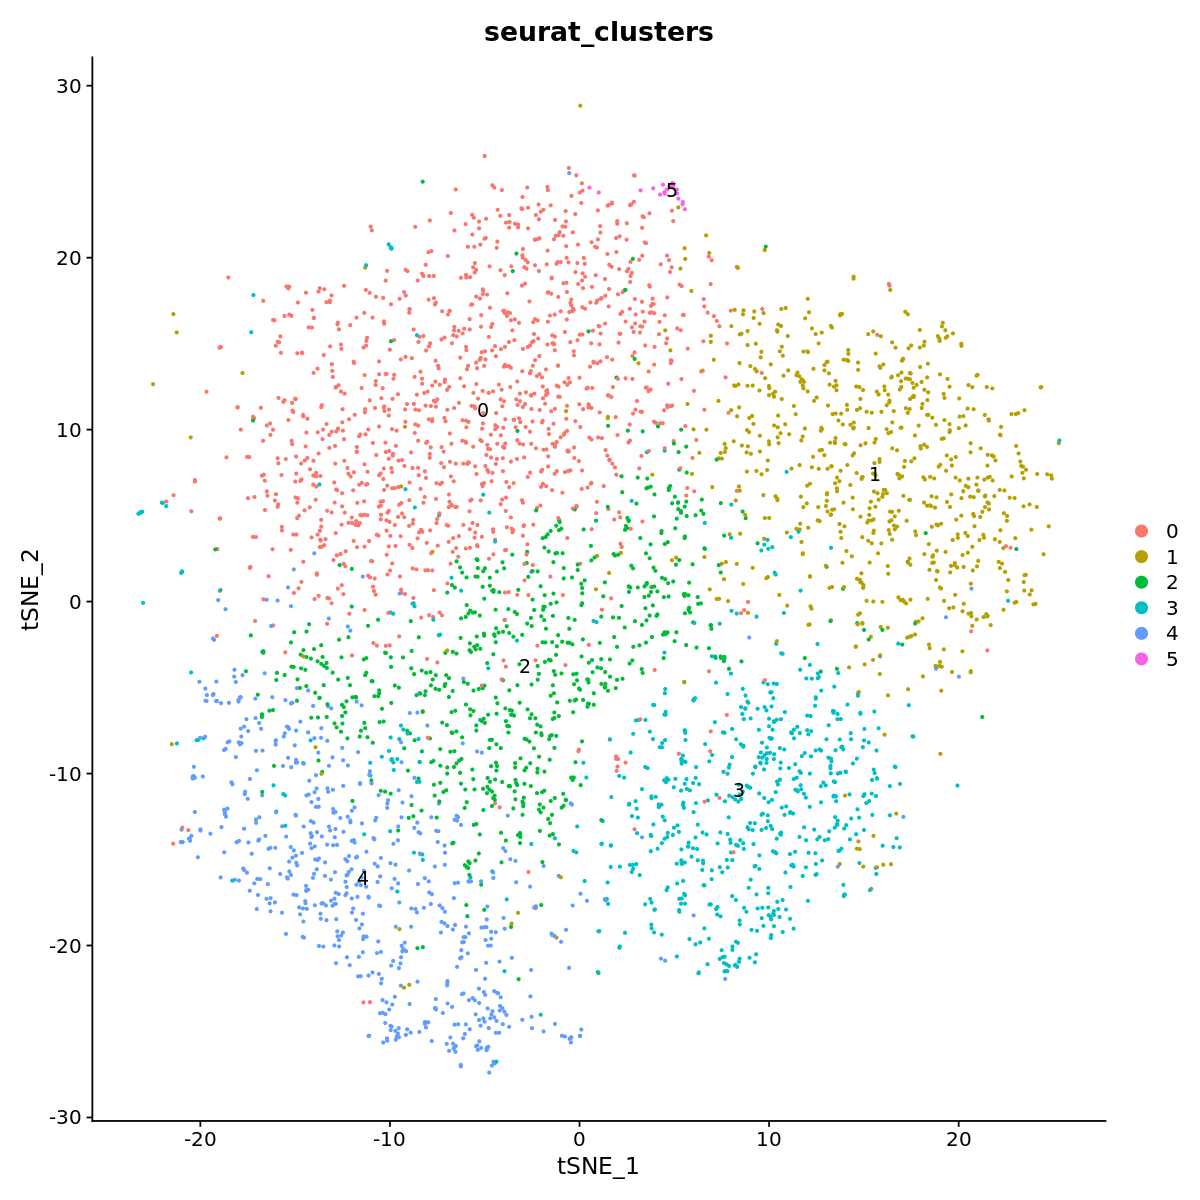

In [58]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(Exp_clust, reduction="tsne", label = TRUE, group.by='seurat_clusters',  pt.size = 0.5)

In [59]:
Exp_clust_umap <- FindNeighbors(clust2_umap, dims= 1:10)
Exp_clust_umap <- FindClusters(Exp_clust_umap, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4036
Number of edges: 125037

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7692
Number of communities: 6
Elapsed time: 0 seconds


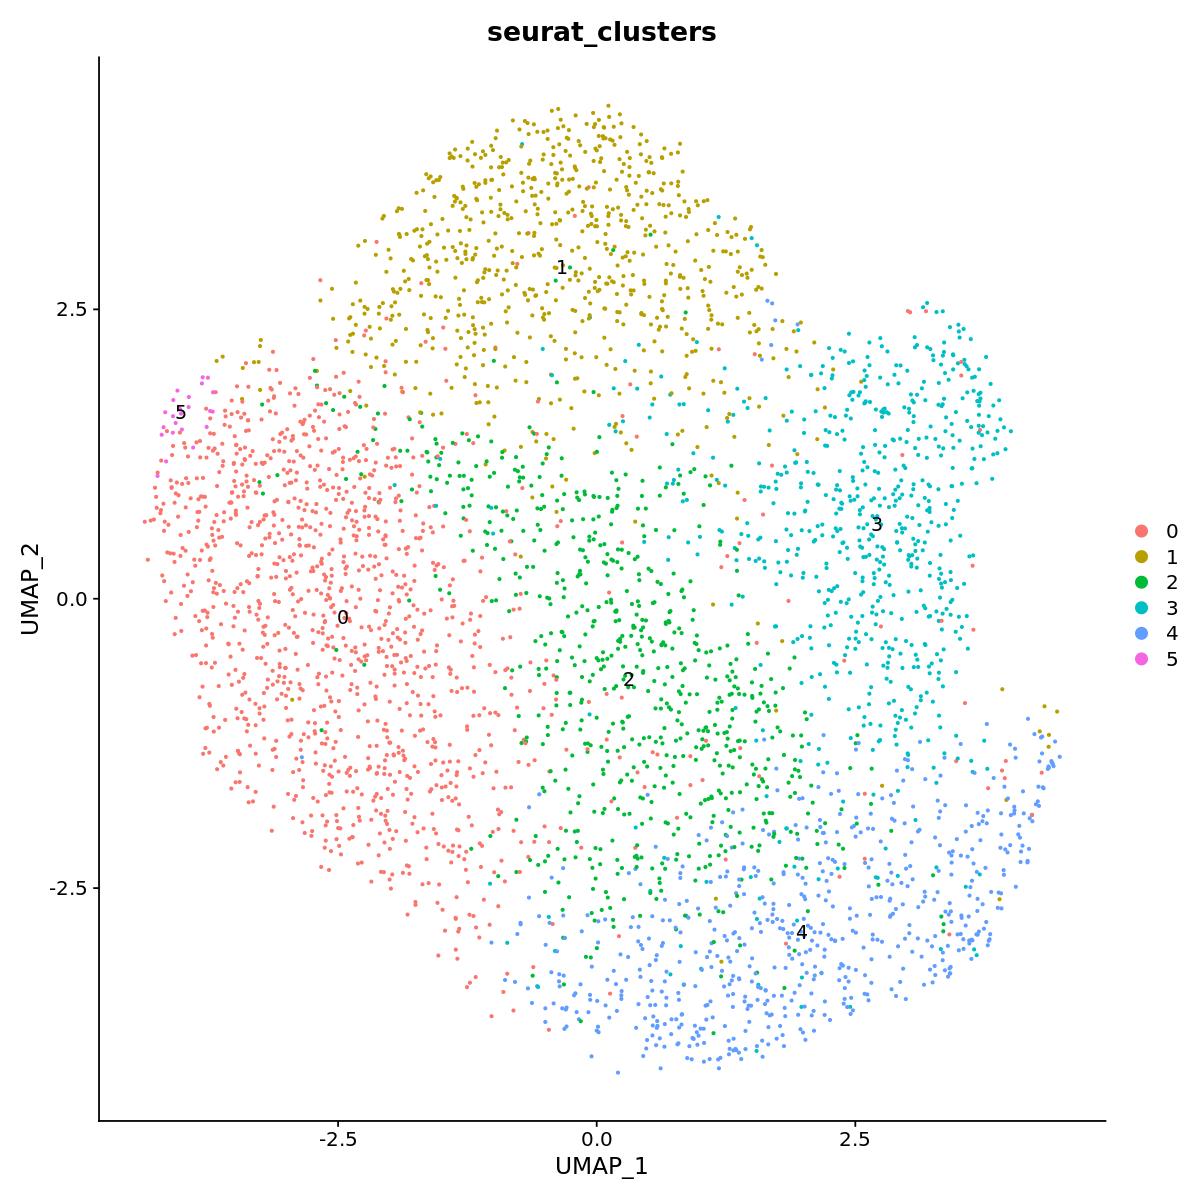

In [60]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(Exp_clust_umap, reduction="umap", label = TRUE, group.by='seurat_clusters',  pt.size = 0.5)

In [62]:
clust0 <- subset(Exp_clust, ident=c('0'))
clust1 <- subset(Exp_clust, ident=c('1'))
clust2 <- subset(Exp_clust, ident=c('2'))
clust3 <- subset(Exp_clust, ident=c('3'))
clust4 <- subset(Exp_clust, ident=c('4'))
clust5 <- subset(Exp_clust, ident=c('5'))


In [63]:
write.xlsx(rownames(clust0@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster0 barcodes", row.names=TRUE)
write.xlsx(rownames(clust1@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster1 barcodes", append=TRUE, row.names=TRUE)
write.xlsx(rownames(clust2@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster2 barcodes",append=TRUE, row.names=TRUE)
write.xlsx(rownames(clust3@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster3 barcodes", append=TRUE,row.names=TRUE)
write.xlsx(rownames(clust4@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster4 barcodes",append=TRUE, row.names=TRUE)
write.xlsx(rownames(clust5@meta.data), file="cluster 2 subset barcodes.xlsx", sheetName="cluster5 barcodes", append=TRUE,row.names=TRUE)


In [27]:
Exp_clust$seurat_clusters -> Idents(Exp_clust)

In [21]:
#T
cluster0.markers <- FindMarkers(Exp_clust, ident.1 =0, min.pct = 0.25)
cluster1.markers <- FindMarkers(Exp_clust, ident.1 =1, min.pct = 0.25)
cluster2.markers <- FindMarkers(Exp_clust, ident.1 =2, min.pct = 0.25)
cluster3.markers <- FindMarkers(Exp_clust, ident.1 =3, min.pct = 0.25)
cluster4.markers <- FindMarkers(Exp_clust, ident.1 =4, min.pct = 0.25)
cluster5.markers <- FindMarkers(Exp_clust, ident.1 =5, min.pct = 0.25)

In [22]:
write.xlsx(cluster0.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster0", row.names=TRUE)
write.xlsx(cluster1.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster1", append=TRUE, row.names=TRUE)
write.xlsx(cluster2.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster2", append=TRUE, row.names=TRUE)
write.xlsx(cluster3.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster3", append=TRUE, row.names=TRUE)
write.xlsx(cluster4.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster4", append=TRUE, row.names=TRUE)
write.xlsx(cluster5.markers, file="Cluster2_recluster_DE.xlsx", sheetName="cluster5", append=TRUE, row.names=TRUE)

In [44]:
clust0 <- subset(Exp_clust, idents = c("0"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust0) <- "letter.ids"
clust0.markers <- FindMarkers(clust0, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [45]:
clust1 <- subset(Exp_clust, idents = c("1"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust1) <- "letter.ids"
clust1.markers <- FindMarkers(clust1, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [46]:
clust2 <- subset(Exp_clust, idents = c("2"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust2) <- "letter.ids"
clust2.markers <- FindMarkers(clust2, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [47]:
clust3 <- subset(Exp_clust, idents = c("3"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust3) <- "letter.ids"
clust3.markers <- FindMarkers(clust3, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [48]:
clust4 <- subset(Exp_clust, idents = c("4"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust4) <- "letter.ids"
clust4.markers <- FindMarkers(clust4, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [49]:
clust5 <- subset(Exp_clust, idents = c("5"), do.clean = TRUE, do.scale = TRUE)
Idents(object=clust5) <- "letter.ids"
clust5.markers <- FindMarkers(clust5, ident.1 ="B", ident.2="D", min.pct = 0.25)

Warning message:
"The following arguments are not used: do.clean, do.scale"


In [51]:
write.xlsx(clust0.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster0", row.names=TRUE)
write.xlsx(clust1.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster1", append=TRUE, row.names=TRUE)
write.xlsx(clust2.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster2", append=TRUE, row.names=TRUE)
write.xlsx(clust3.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster3", append=TRUE, row.names=TRUE)
write.xlsx(clust4.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster4", append=TRUE, row.names=TRUE)
write.xlsx(clust5.markers, file="Cluster2_recluster_BvsD_DE.xlsx", sheetName="cluster5", append=TRUE, row.names=TRUE)

In [39]:
Exp_clust$letter.ids -> Idents(Exp_clust)

In [55]:
unique(Idents(Exp_clust))

[1] 4 0 1 3 2 5
Levels: 0 1 2 3 4 5

In [40]:
A <- subset(Exp_clust, idents=c('A'))
B <- subset(Exp_clust, idents=c('B'))
C <- subset(Exp_clust, idents=c('C'))
D <- subset(Exp_clust, idents=c('D'))

In [41]:
A$seurat_clusters -> Idents(A)
B$seurat_clusters -> Idents(B)
C$seurat_clusters -> Idents(C)
D$seurat_clusters -> Idents(D)

In [42]:
a_avg <- AverageExpression(A, assay='RNA')
b_avg <- AverageExpression(B, assay='RNA')
c_avg <- AverageExpression(C, assay='RNA')
d_avg <- AverageExpression(D, assay='RNA')

In [46]:
openxlsx::write.xlsx(a_avg, file="Cluster2_recluster_AvgExp_byGroup_a.xlsx", sheetName="GroupA", row.names=TRUE)
openxlsx::write.xlsx(b_avg, file="Cluster2_recluster_AvgExp_byGroup_b.xlsx", sheetName="GroupB", row.names=TRUE)
openxlsx::write.xlsx(c_avg, file="Cluster2_recluster_AvgExp_byGroup_c.xlsx", sheetName="GroupC", row.names=TRUE)
openxlsx::write.xlsx(d_avg, file="Cluster2_recluster_AvgExp_byGroup_d.xlsx", sheetName="GroupD", row.names=TRUE)

S203AKI_0110 S203AKI_1670_DSS WT_0112 WT_1669_DSS S203AKI_1652_DSS
0 138          118              162     191         164             
1  22          191               45     142         113             
2  10          217               22     157         125             
3  28          182               51     145          81             
4  22          263               15     131          74             
5   1            7                1       7           3             
  S203AKI_1810 WT_1653_DSS WT_1813
0 128          193         157    
1  28          166          43    
2  14          162           8    
3  23          120          39    
4   9           97          17    
5   2            1           1

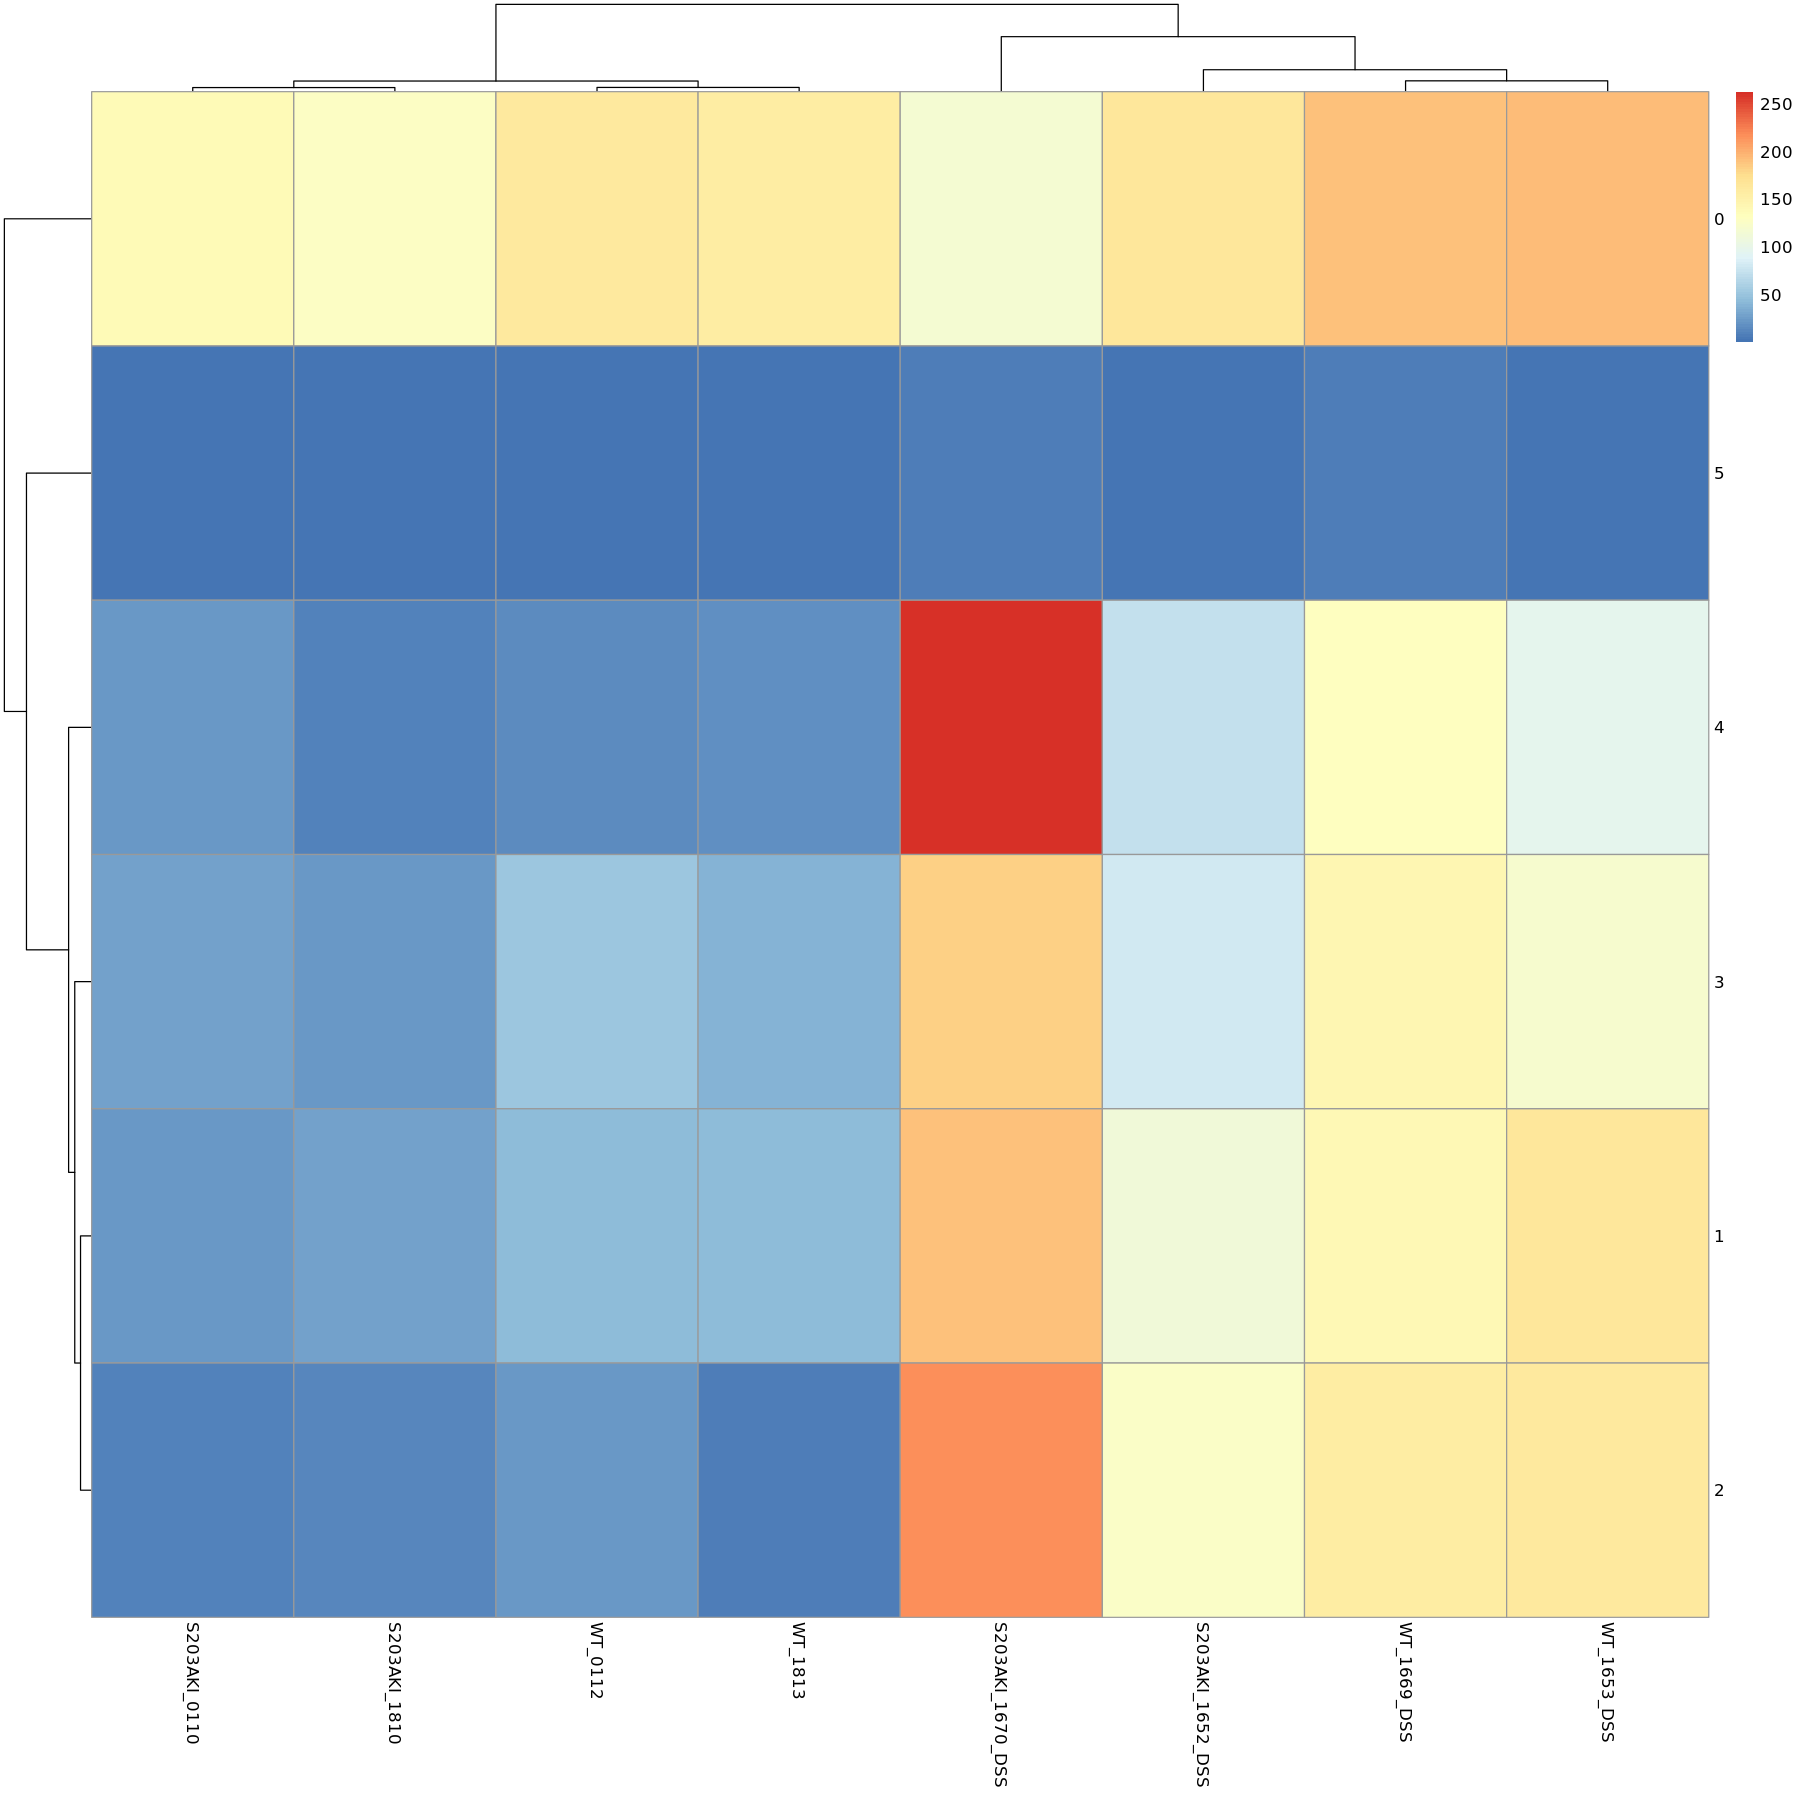

In [28]:
options(repr.plot.width = 15, repr.plot.height = 15)
# plotting heatmap and making table of cells per cluster per sample
# Percentage of samples in each cluster
pos <- data.frame(matrix(ncol = 8, nrow = 6))
tot <- data.frame(matrix(ncol = 8, nrow = 6))
sum_byrow <- data.frame(matrix(ncol = 8, nrow = 6))
cond <- c('S203AKI_0110','S203AKI_1670_DSS','WT_0112','WT_1669_DSS',
'S203AKI_1652_DSS','S203AKI_1810','WT_1653_DSS','WT_1813')

for (i in c(1:6)) {
    for (j in c(1:8)) {
        pos[i, j] <- sum(Exp_clust@meta.data$orig.ident[Exp_clust@meta.data$seurat_clusters == (i - 1)] == cond[j])
        #tot[i, j] <- sum(Exp_clust@meta.data$RNA_snn_res.1.3  == (i - 1))
        sum_byrow[i, j] <- pos[i, j] 
    }
}

colnames(sum_byrow) <- cond
rownames(sum_byrow) <- c(0:5)
heatmap_byrow <- pheatmap(as.matrix(sum_byrow), cexRow = 1, cexCol = 1, xlab = "Sample", ylab = "Cluster",margins = c(10,5), keep.dendro = FALSE)
write.xlsx(sum_byrow, 'Cluster2_recluster_counts_per_sample.xlsx')
sum_byrow

In [ ]:
Could you help make the following violin plot based on the Cluster2_re-cluster analysis?
Il10 (Cluster2_sub Cluster#3 cells only): x-axis category to include A-C-B-D
 
Could you also help make the following violin plots based on the 3/19_version04/02
analysis? The first two genes showed up on several DE (AvsC and BvsD) list as 
significant hits, we are thinking to present a figure panel to highlight changes 
      in the IL-1 receptor signaling pathway.
Il1r1 (3/19 Cluster0)A-C-B-D + (3/19 Cluster3)A-C-B-D
Il1r2 (3/19 Cluster0)A-C-B-D + (3/19 Cluster3)A-C-B-D
Il1rap (3/19 Cluster0)A-C-B-D + (3/19 Cluster3)A-C-B-D
 
For the Cluster2_recluster AvgExp file, can you expand to include the average expression 
of each gene in sub-Cluster 0-5 from Group A/B/C/D separately (e.g. one tab for sample A,
one tab for sample B etc)?

In [35]:
unique(Idents(Exp_clust))

[1] 4 0 1 3 2 5
Levels: 0 1 2 3 4 5

In [91]:
clust3 <- subset(Exp_clust, idents='3')

In [92]:
Idents(clust3) <- clust3$letter.ids

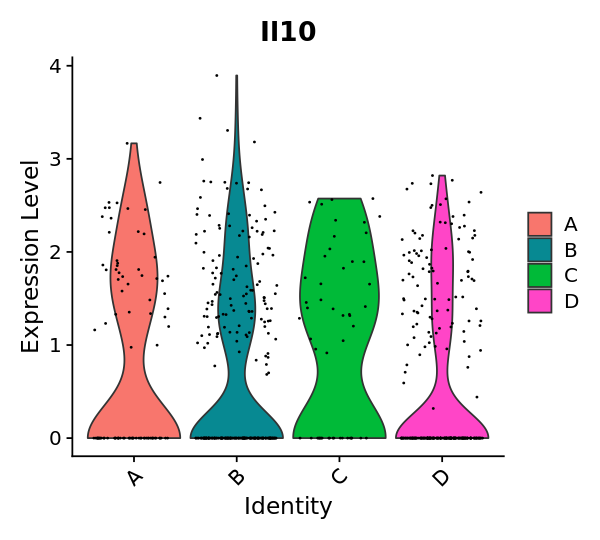

In [94]:
features<- c('Il10')
options(repr.plot.width = 5, repr.plot.height = 4.5)
VlnPlot(obj = clust3, features = features, cols= c('#f8766d', '#078992', '#00ba38', '#ff45c7'))

In [19]:
clust0_3 <- subset(test, idents=c('0','3'))

In [33]:
p1 <- VlnPlot(obj = clust0_3, ncol=1, features = 'Il1r1', split.by='letter.ids', group.by='seurat_clusters',
       cols= c('#f8766d', '#078992', '#00ba38', '#ff45c7'))
p2 <- VlnPlot(obj = clust0_3, ncol=1, features = 'Il1r2', split.by='letter.ids', group.by='seurat_clusters',
       cols= c('#f8766d', '#078992', '#00ba38', '#ff45c7'))
p3 <- VlnPlot(obj = clust0_3, ncol=1, features = 'Il1rap', split.by='letter.ids', group.by='seurat_clusters',
       cols= c('#f8766d', '#078992', '#00ba38', '#ff45c7'))


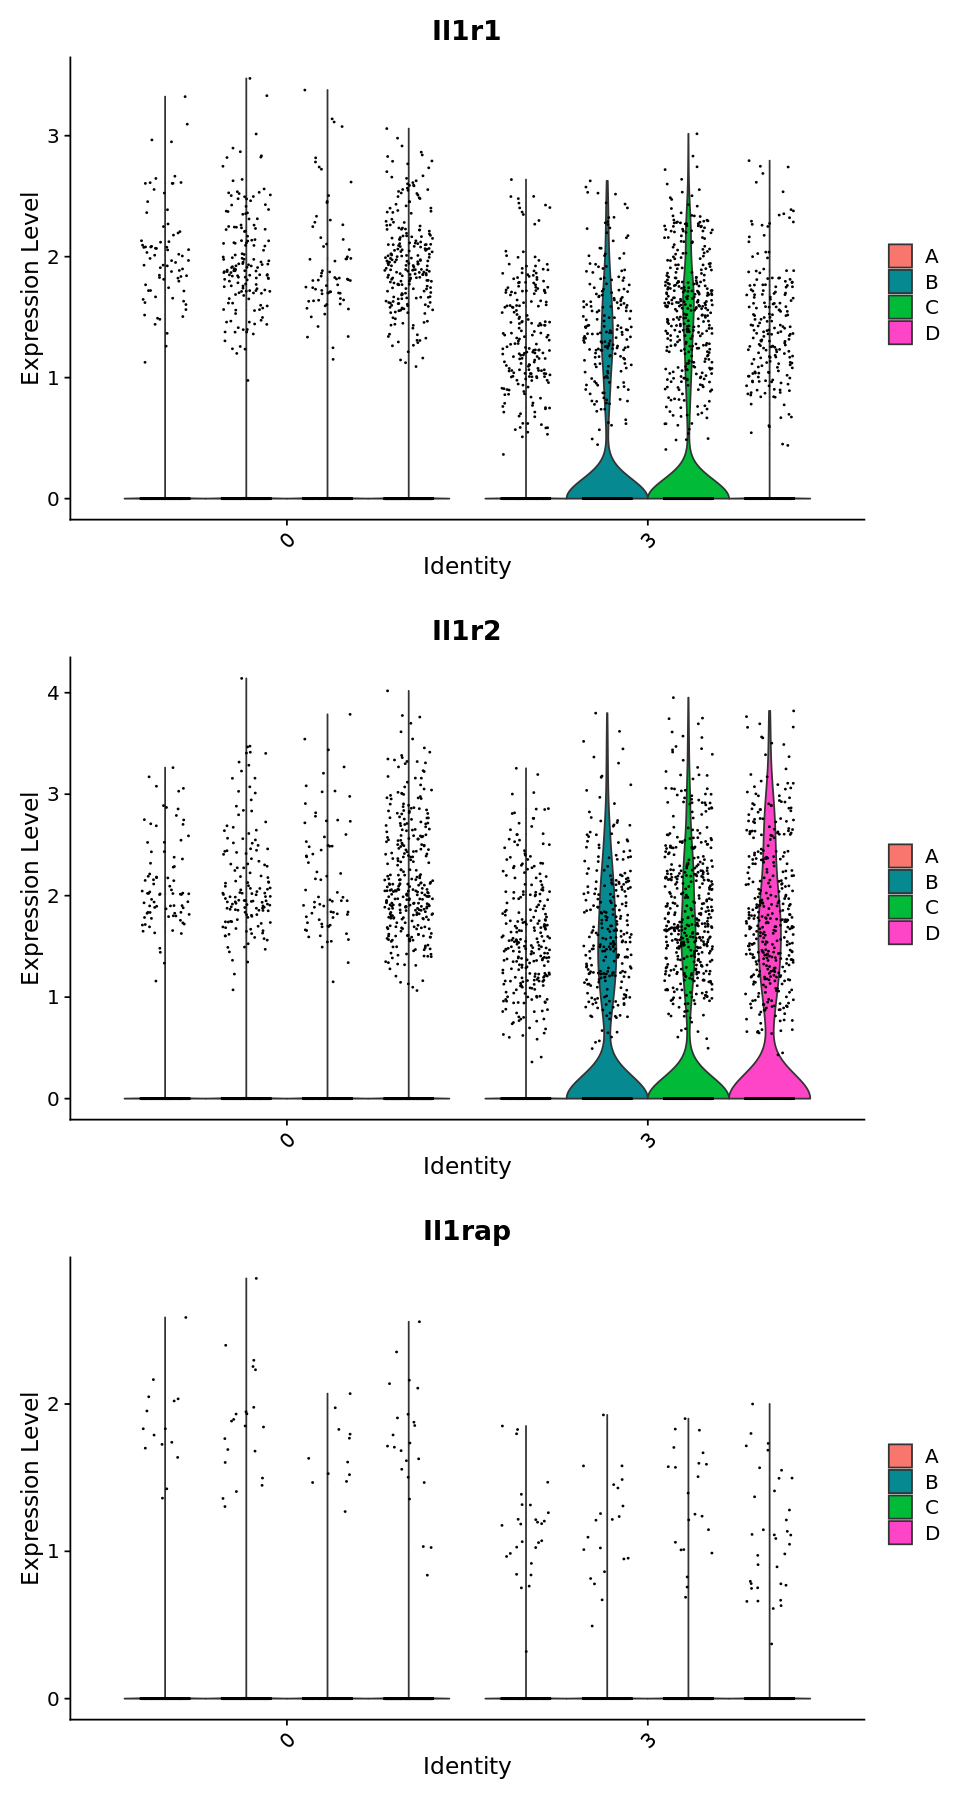

In [34]:
options(repr.plot.width = 8, repr.plot.height = 15)
plot_grid(p1, p2, p3, ncol = 1)

In [ ]:
#UMAP (A/B/C/D group separated) showing Il1r1 (please follow same color/style as shown in attached Slide #1: top)
#Violin plot of Il1r1 (please follow same color/style as shown in Slide #1: bottom) 
#Can you make a zoomed-in UMAP on Cluster2 and overlay the re-cluster cells in subpopulation 0-4 in different colors? (see rough idea in attached Slide #2)

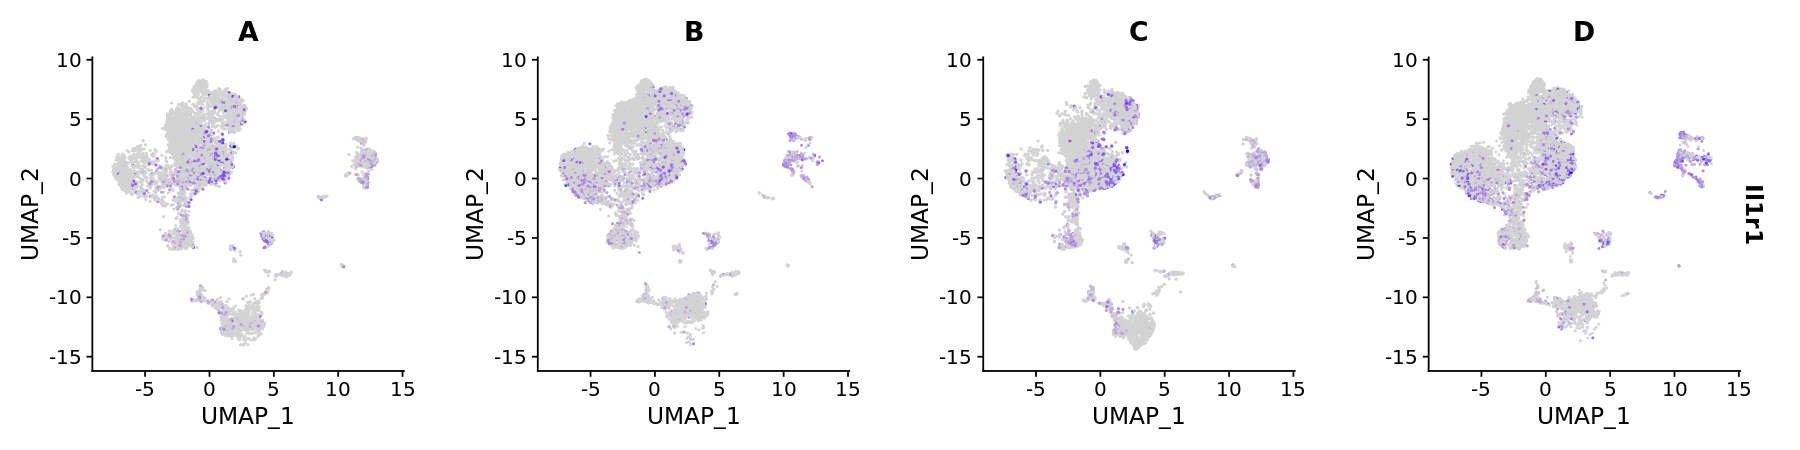

In [23]:
options(repr.plot.width = 15, repr.plot.height = 3.75)
FeaturePlot(test_umap, features=c('Il1r1'), split.by='letter.ids',ncol=1)

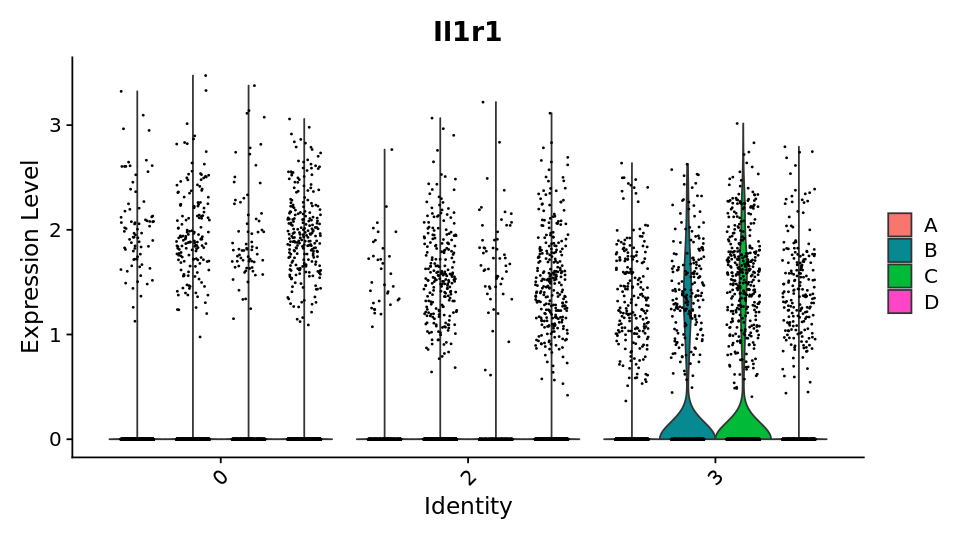

In [29]:
options(repr.plot.width = 8, repr.plot.height = 4.5)
VlnPlot(obj = fig1, ncol=1, features = 'Il1r1', split.by='letter.ids', group.by='seurat_clusters',
       cols= c('#f8766d', '#078992', '#00ba38', '#ff45c7'))

In [73]:
dim_plot <- DimPlot(test_umap, reduction='umap', group.by='seurat_clusters',cells.highlight= list(clust0_names,clust1_names,clust2_names,clust3_names,clust4_names),
        order=c('clust0_names','clust1_names','clust2_names','clust3_names','clust4_names','Unselected'))


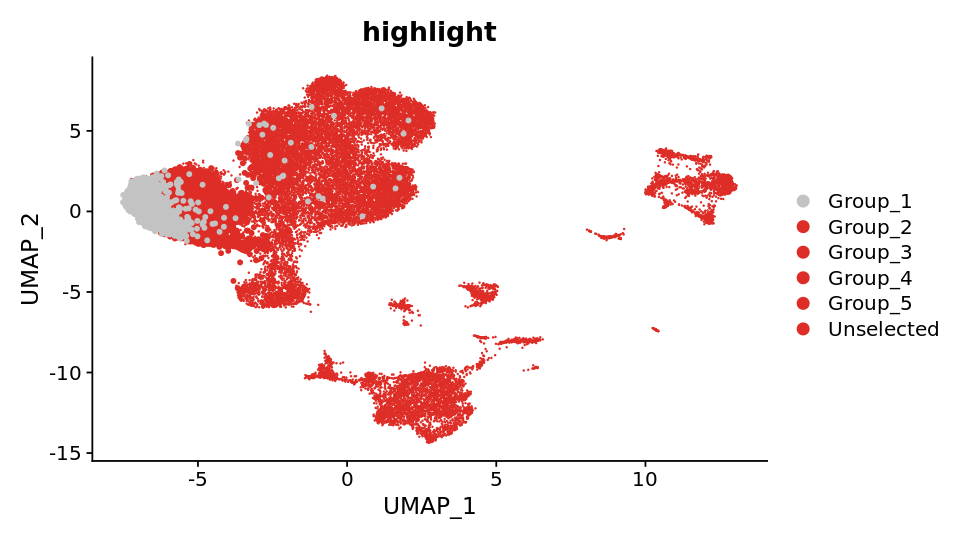

In [74]:
dim_plot$data$highlight <- factor(x = dim_plot$data$highlight, levels = c('Group_1','Group_2','Group_3','Group_4','Group_5','Unselected')) # change the order of the factor levels
dim_plot # print again the plot

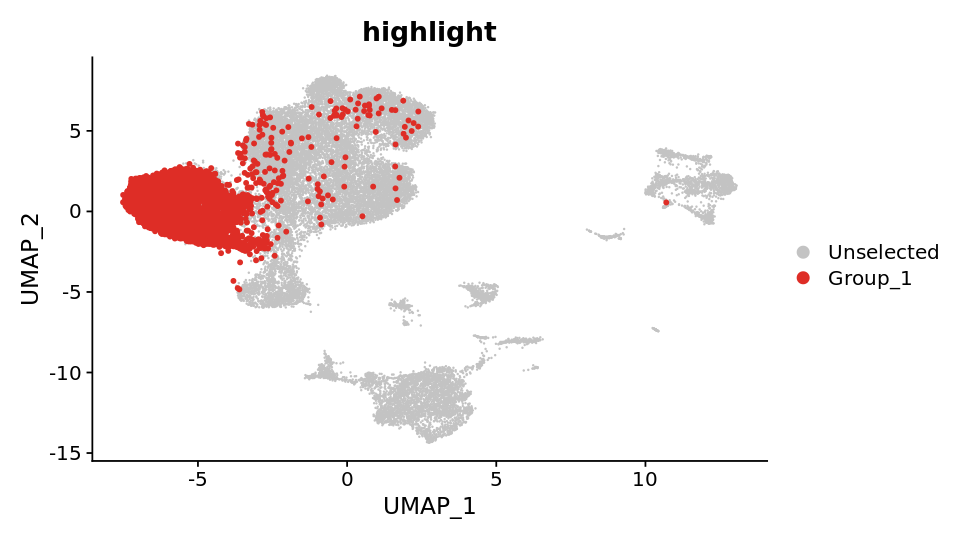

In [96]:
DimPlot(test_umap, reduction='umap', group.by='seurat_clusters',cells.highlight= colnames(Exp_clust))

In [105]:
t3 <- DimPlot(test_umap, reduction='umap',cells.highlight= list(clust0_names,clust1_names,clust2_names,clust3_names,clust4_names),
       cols.highlight= c('Group_5'='red','Group_4'='green','Group_3'='yellow','Group_2'='orange','Group_1'='purple'))


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



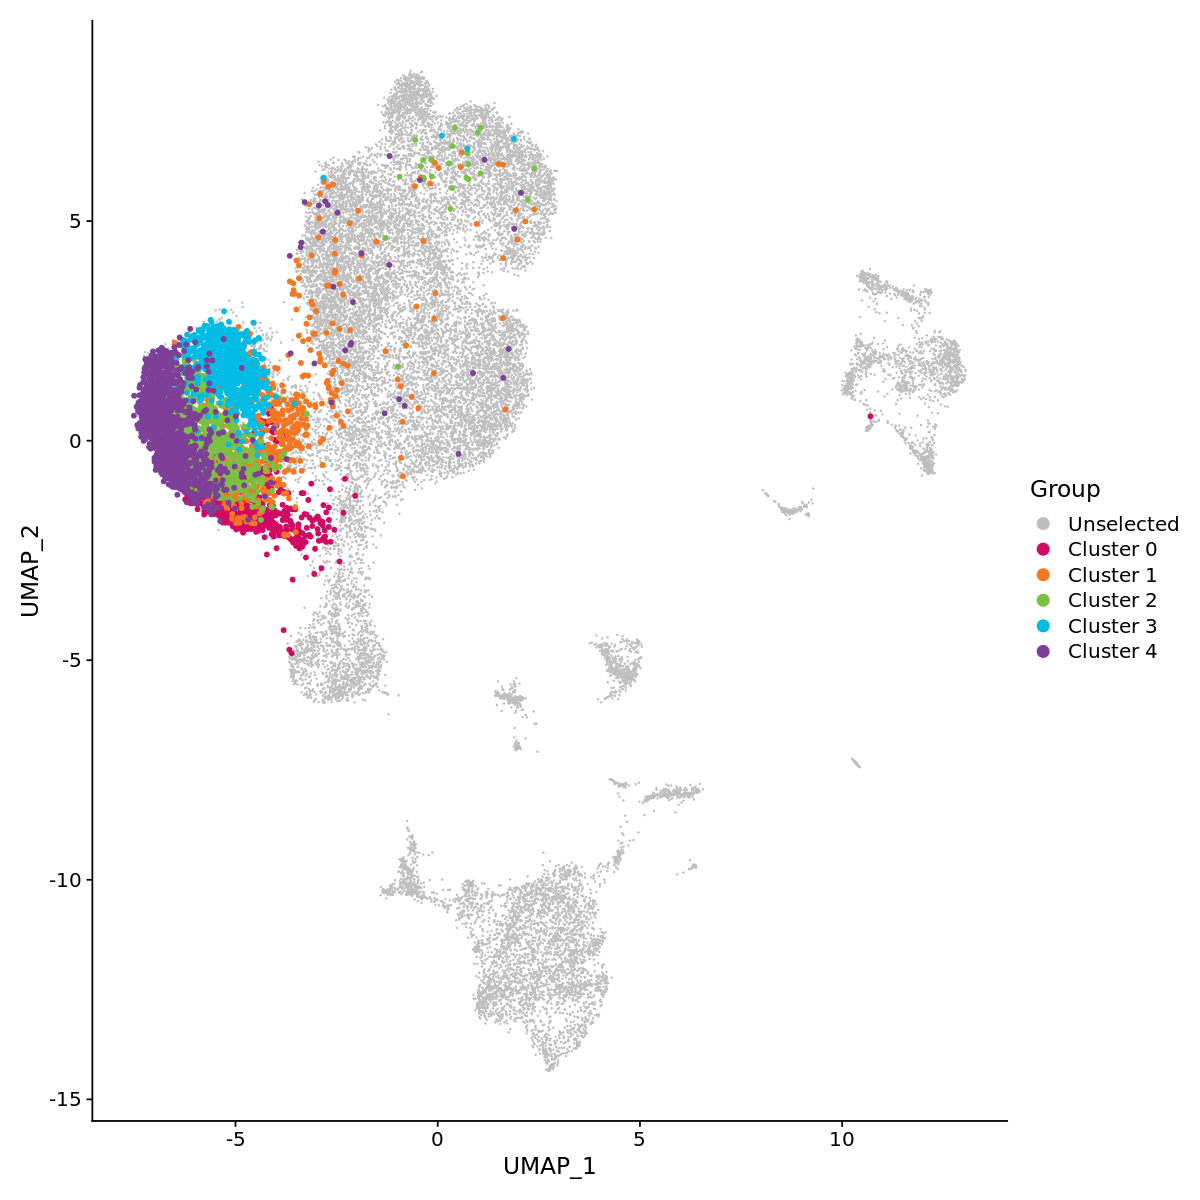

In [123]:
options(repr.plot.width = 10, repr.plot.height = 10)
DimPlot(test_umap, cells.highlight= list(clust0_names,clust1_names,clust2_names,clust3_names,clust4_names), cols.highlight = c('#d20962','#f47721','#7ac143','#00bce4','#7d3f98'), cols= "grey",sizes.highlight = 1) +
scale_color_manual(labels = c('Unselected','Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'), values = c("grey", '#d20962','#f47721','#7ac143','#00bce4','#7d3f98')) +
  labs(color = "Group")

In [110]:
library(readxl)


In [177]:
clust0 <- read_excel('clust2_edit_plot.xlsx', 1)  # read first sheet
clust3<- read_excel('clust2_edit_plot.xlsx', 4)  # read first sheet

New names:
* `` -> ...1

New names:
* `` -> ...1



In [178]:
features <- c('Furin','Nr4a3','Atf4','Gzmb','Smad7')
features2 <- c('Cd44','Id2','Il10','S1pr4','Cd74','Lag3')

In [179]:
clust3 <- clust3 %>%
  mutate(plotname = as.character(...1))


In [180]:
clust3 <- clust3 %>%
  mutate(plotname = ifelse(plotname %in% features2, plotname, ""))

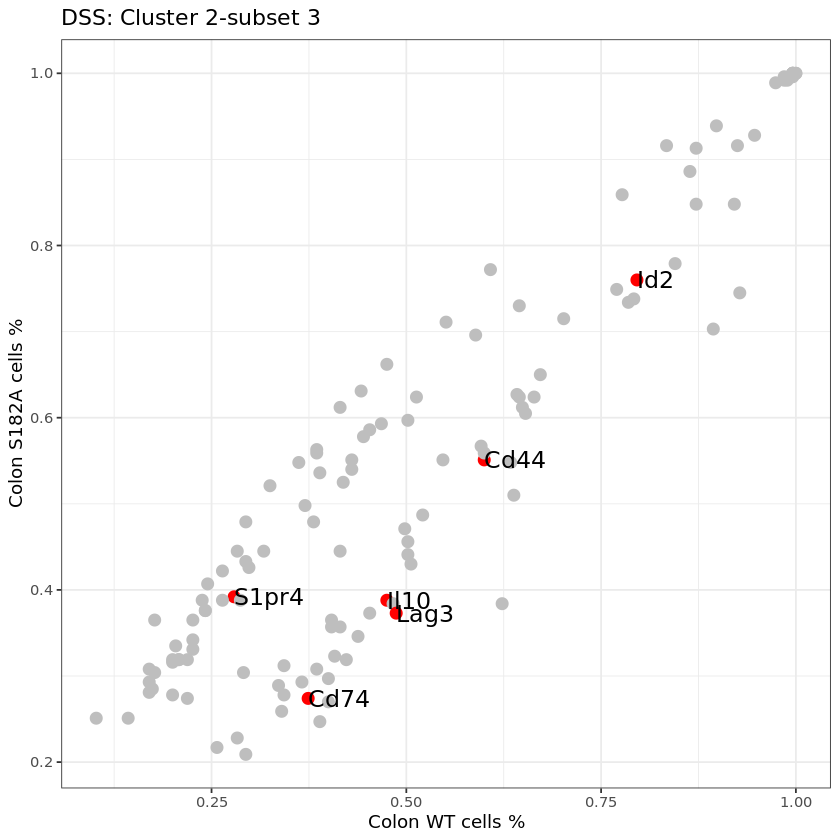

In [184]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(clust3, aes(x = pct.1, y = pct.2)) +
    geom_point(size= 3,aes(color = check)) +
    scale_color_manual(values = c("gray", "red")) +
    geom_text(aes(x = pct.1, label = plotname), size = 5, hjust = 0)+ 
    theme_bw() +
    theme(legend.position='none')+ ggtitle("DSS: Cluster 2-subset 3") +
  xlab("Colon WT cells %") + ylab("Colon S182A cells %")

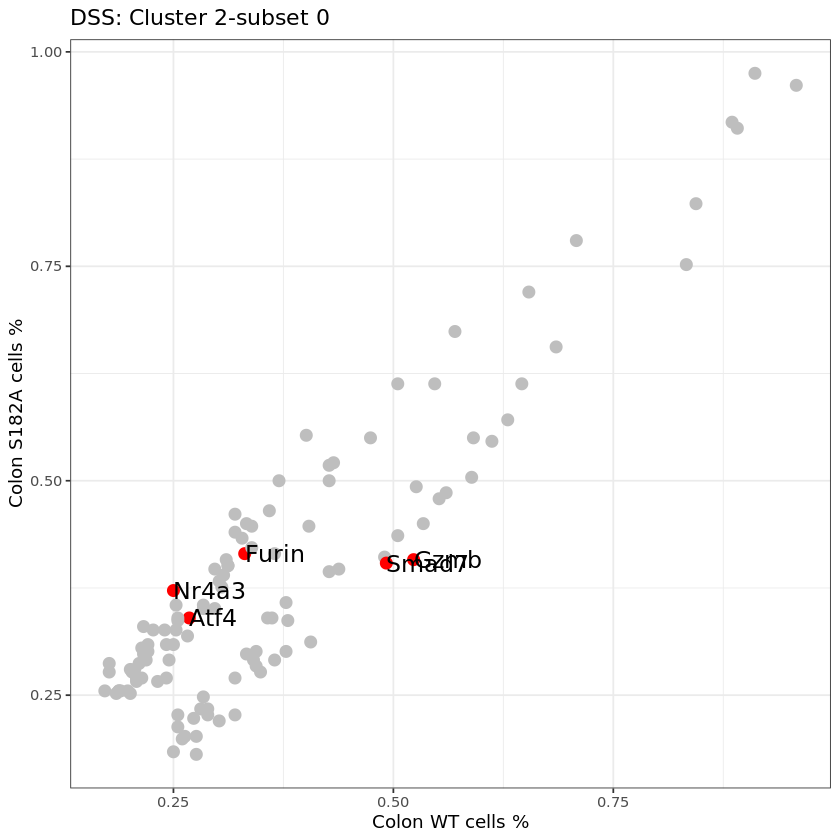

In [172]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(clust, aes(x = pct.1, y = pct.2)) +
    geom_point(size= 3,aes(color = check)) +
    scale_color_manual(values = c("gray", "red")) +
    geom_text(aes(x = pct.1, label = plotname), size = 5, hjust = 0)+ 
    theme_bw() +
    theme(legend.position='none')+ ggtitle("DSS: Cluster 2-subset 0") +
  xlab("Colon WT cells %") + ylab("Colon S182A cells %")

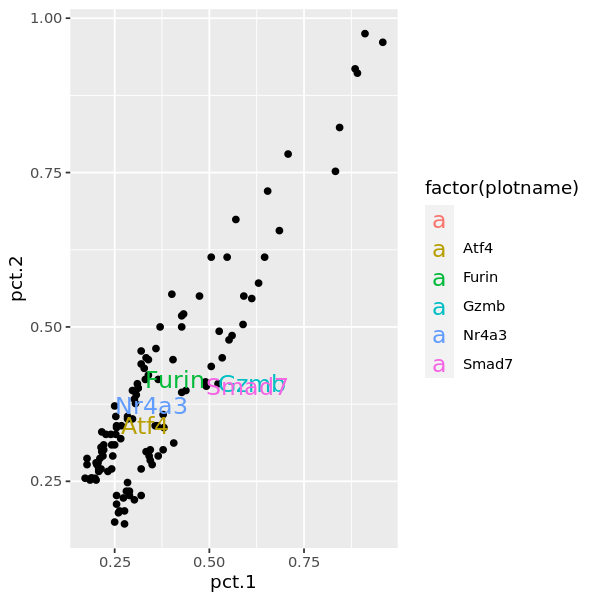

In [150]:
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(clust, aes(x = pct.1, y = pct.2),color=plotname) +
  geom_point() +
  geom_text(aes(x = pct.1, label = plotname), size = 5, hjust = 0)



## For GEO submission

In [ ]:
WT_0112 <- GetAssayData(object = test_split$WT_0112, slot = "count")
WT_1813 <- GetAssayData(object = test_split$WT_1813, slot = "count")
WT_1653_DSS <- GetAssayData(object = test_split$WT_1653_DSS, slot = "count")
WT_1669_DSS <- GetAssayData(object = test_split$WT_1669_DSS, slot = "count")
S203AKI_0110 <- GetAssayData(object = test_split$S203AKI_0110, slot = "count")
S203AKI_1810 <- GetAssayData(object = test_split$S203AKI_1810, slot = "count")
S203AKI_1652_DSS <- GetAssayData(object = test_split$S203AKI_1652_DSS, slot = "count")
S203AKI_1670_DSS <- GetAssayData(object = test_split$S203AKI_1670_DSS, slot = "count")

In [23]:
library(Matrix)
matrix_dir = "/projects/ps-yeolab4/t_cell_p01/home/sap007/analysis/huang/outputs/S203AKI_1670_DSS/outs/filtered_feature_bc_matrix/"
barcode.path <- paste0(matrix_dir, "barcodes.tsv.gz")
features.path <- paste0(matrix_dir, "features.tsv.gz")
matrix.path <- paste0(matrix_dir, "matrix.mtx.gz")
mat2 <- readMM(file = matrix.path)
feature.names = read.delim(features.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
colnames(mat2) = barcode.names$V1
rownames(mat2) = feature.names$V2